# Reference

https://www.kaggle.com/code/sunyoungpark5/kickstarter-success-factors#1-4.-Is-there-seasonality-in-the-success-rate?

https://www.kaggle.com/code/shivamb/an-insightful-story-of-crowdfunding-projects

https://www.kaggle.com/code/matleonard/feature-generation

https://github.com/L-Lewis/Kickstarter-success-machine-learning/blob/master/Kickstarter-project.ipynb

https://scikit-learn.org/stable/modules/feature_selection.html

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

https://www.kaggle.com/code/loredanagheorghe/eda-imputation-pipeline-xgboost-shap/notebook


In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', 100) # Display up to 100 columns at a time
import numpy as np
import matplotlib
from matplotlib import pyplot as plt, cm
plt.style.use('seaborn-v0_8')
import seaborn as sns
from plotly import tools
from datetime import datetime
import ast
import json
import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils.fixes import parse_version
from collections import Counter, defaultdict
from scipy.stats import chi2_contingency
from pdpbox import pdp, info_plots
from eli5.sklearn import PermutationImportance
import eli5


# 1. Data Loading

In [3]:
# pre-combined data, save time for each start
pre_combined_data = 1

if pre_combined_data == 0:
    folder = 'Dataset/Kickstarter_2025-06-12T03_20_15_713Z'
    
    data = pd.DataFrame()
    
    for file in os.listdir(folder):
        if data.shape[0] == 0:
            data = pd.read_csv(os.path.join(folder, file))
            data['file_source'] = file
        else:
            df1 = pd.read_csv(os.path.join(folder, file))
            df1['file_source'] = file
            data = pd.concat([data, df1], ignore_index=True)

    data.to_csv('Dataset/Kickstarter1.csv', index=False)
    
else:
    data = pd.read_csv('Dataset/Kickstarter1.csv', header=0)

In [4]:
print(data.shape)
data.head()

(259976, 43)


,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,fx_rate,goal,id,is_disliked,is_in_post_campaign_pledging_phase,is_launched,is_liked,is_starrable,launched_at,location,name,percent_funded,photo,pledged,prelaunch_activated,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_exchange_rate,usd_pledged,usd_type,video,file_source
0,72,Recruit Wayward Souls for The Devil with money...,"{""id"":34,""name"":""Tabletop Games"",""analytics_na...",1156.0,US,the United States,1738346894,"{""id"":1553589136,""name"":""Bug Boll"",""slug"":""bom...",USD,$,True,USD,1740790045,False,1.0,666.0,1217652979,False,True,True,False,False,1738630045,"{""id"":2383660,""name"":""Columbus"",""slug"":""columb...",The Devil's Doorbell,173.573574,"{""key"":""assets/048/185/126/d338efd810b44303dbc...",1156.0,True,"{""id"":5121837,""project_id"":5121837,""state"":""in...",the-devils-doorbell,https://www.kickstarter.com/discover/categorie...,True,True,successful,1740790050,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",1.0,1156.0,domestic,NaN,Kickstarter.csv
1,83,Embark on a Spacefaring Adventure of Honor and...,"{""id"":34,""name"":""Tabletop Games"",""analytics_na...",3966.0,US,the United States,1715698286,"{""id"":1189745891,""name"":""Gamenomicon"",""slug"":""...",USD,$,True,USD,1740182400,False,1.0,2000.0,1537795415,False,True,True,False,False,1738424228,"{""id"":2498315,""name"":""Springfield"",""slug"":""spr...",Honorbound: A Wound by Tension TTRPG - Zineque...,198.300000,"{""key"":""assets/048/040/346/a6039a9bd83e0f1a58e...",3966.0,True,"{""id"":4859507,""project_id"":4859507,""state"":""in...",honorbound-0,https://www.kickstarter.com/discover/categorie...,True,False,successful,1740182403,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",1.0,3966.0,domestic,"{""id"":1339374,""status"":""successful"",""hls"":""htt...",Kickstarter.csv
2,0,I waited 50yrs. Have always desired to record ...,"{""id"":318,""name"":""Faith"",""analytics_name"":""Fai...",0.0,US,the United States,1430773217,"{""id"":2125438377,""name"":""Dearick Milton Sr."",""...",USD,$,True,USD,1433451307,False,1.0,25000.0,1845488351,False,NaN,True,False,False,1430859307,"{""id"":2357024,""name"":""Atlanta"",""slug"":""atlanta...",Free To Worship,0.000000,"{""key"":""assets/012/128/083/804385f8322e32f5a73...",0.0,False,"{""id"":1880069,""project_id"":1880069,""state"":""in...",free-to-worship,https://www.kickstarter.com/discover/categorie...,False,False,failed,1433451307,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",1.0,0.0,domestic,NaN,Kickstarter.csv
3,2,"A beautiful blend of thoughts , feelings and s...","{""id"":318,""name"":""Faith"",""analytics_name"":""Fai...",30.0,US,the United States,1356314466,"{""id"":63320003,""name"":""Marcella Ratcliff"",""is_...",USD,$,True,USD,1432935000,False,1.0,4000.0,1147933403,False,NaN,True,False,False,1430596219,"{""id"":2359991,""name"":""Baton Rouge"",""slug"":""bat...",Marcella's Self Titled debut EP,0.750000,"{""key"":""assets/011/462/797/bcf8ce5a77116e24d01...",30.0,False,"{""id"":428989,""project_id"":428989,""state"":""inac...",marcellas-self-titled-debut-ep,https://www.kickstarter.com/discover/categorie...,False,False,failed,1432935015,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",1.0,30.0,domestic,NaN,Kickstarter.csv
4,107,A father in a Texas town resorts to desperate ...,"{""id"":31,""name"":""Narrative Film"",""analytics_na...",25025.0,US,the United States,1563017492,"{""id"":1409806703,""name"":""Theresa Gallagher"",""s...",USD,$,True,USD,1569307500,False,1.0,20000.0,1230401809,False,NaN,True,False,False,1564364624,"{""id"":2370568,""name"":""Brownsville"",""slug"":""bro...",The Promise,125.125000,"{""key"":""assets/025/930/611/81792be134d0039c9ee...",25025.0,False,"{""id"":3772022,""project_id"":3

In [5]:
data.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'country_displayable_name', 'created_at', 'creator',
       'currency', 'currency_symbol', 'currency_trailing_code',
       'current_currency', 'deadline', 'disable_communication', 'fx_rate',
       'goal', 'id', 'is_disliked', 'is_in_post_campaign_pledging_phase',
       'is_launched', 'is_liked', 'is_starrable', 'launched_at', 'location',
       'name', 'percent_funded', 'photo', 'pledged', 'prelaunch_activated',
       'profile', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'urls', 'usd_exchange_rate',
       'usd_pledged', 'usd_type', 'video', 'file_source'],
      dtype='object')

# 2. Data Preprocessing

#### Drop duplicates

As we combine data from different periods, some campaigns might be recorded more than once, and their state could change as well. We will keep the last record of each campaign id, as the state could change from 'live' to 'successful' or 'failed'

In [6]:
a = data.shape[0]
print(f'Before remove duplicates: {a} rows')
data.drop_duplicates(subset='id', keep='last', inplace=True)
print(f'After remove duplicates: {data.shape[0]} rows')
print(f'{a  - data.shape[0]} rows removed.')

Before remove duplicates: 259976 rows
After remove duplicates: 206323 rows
53653 rows removed.


## 2.1 Convert time data from unix to normal format

In [7]:
data['created_at_datetime'] = data['created_at'].apply(lambda unix: datetime.fromtimestamp(unix))
data['launched_at_datetime'] = data['launched_at'].apply(lambda unix: datetime.fromtimestamp(unix))
data['deadline_datetime'] = data['deadline'].apply(lambda unix: datetime.fromtimestamp(unix))

idx = np.random.randint(0, data.shape[0])
print(f'Project {idx} was created at {data.iloc[idx]['created_at_datetime']}, launched at {data.iloc[idx]['launched_at_datetime']}, and deadline at {data.iloc[idx]['deadline_datetime']}')

Project 22450 was created at 2022-06-24 08:01:44, launched at 2024-06-01 12:00:21, and deadline at 2024-07-01 12:00:21


## 2.2 Adding more datetime columns as variables

<ul>
    <li>launch year (only for checking, not used for models)</li>
    <li>launch month</li>
    <li>launch week</li>
    <li>launch day of the week</li>
    <li>launch in weekend (Y/N)</li>
    <li>duration, from launch time to deadline (days)</li>
</ul>

In [8]:
data['launched_year']         = data['launched_at_datetime'].dt.year
data['launched_month']        = data['launched_at_datetime'].dt.month
data['launched_month_name']    = data['launched_at_datetime'].dt.month_name
data['launched_week']         = data['launched_at_datetime'].dt.isocalendar().week
data['launched_weekday']      = data['launched_at_datetime'].dt.day_name()
data['launched_weekday_number'] = data['launched_at_datetime'].dt.weekday
data['launched_is_weekend']   = data['launched_weekday'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
data['pre_launch_time']       = data['launched_at_datetime'] - data['created_at_datetime']
data['pre_launch_time']       = data['pre_launch_time'].dt.days
data['quarter']               = data['launched_at_datetime'].dt.quarter
quarter = pd.get_dummies(data['launched_at_datetime'].dt.quarter)
quarter.columns = ['q1', 'q2', 'q3', 'q4']
data = pd.concat([data, quarter], axis=1)
data['duration']              = data['deadline_datetime'] - data['launched_at_datetime']
data['duration']              = data['duration'].dt.days

In [9]:
# There are some false records before 2000, which are obvious wrong to have
data = data[data['launched_year'] > 2000]

## 2.3 State of a campaign
<ul>
    <li>Failed - projects that haven't reached the goal withing the deadline. It's interesting to note that the the time for completing a Kickstarter project is limited from 1 to 60 days.</li>
    <li>Live – active projects</li>
    <li>Successful – projects that have reached the amount of money they pledged</li>
    <li>Canceled – projects that were canceled by their creator. The reasons can be numeral, and the creator cannot relaunch the same project.</li>
    <li>Suspended – projects that have violated the terms of the platform. Main cases include providing false information, artificially increasing backers, the creator is presenting someone else’s work as their own or is offering purchased items, claiming to have made them.</li>
</ul>
Hope this helps future analysis on the datasets. More information can be found online which can redirect you to a FAQ page of the platform where such specifics are discussed.


In [10]:
data['state'].value_counts()

state
successful    113802
failed         72578
canceled        9121
live            3264
Name: count, dtype: int64

In [11]:
# convert some states into failed
# only select 2 state: successfull or failed
data['state2'] = data['state'].apply(lambda x: x if x in ['successful', 'live', 'started'] else 'failed')
data = data[data['state2'].isin(['successful', 'failed'])]
data['state3'] = data['state2'].apply(lambda x: 1 if x == 'successful' else 0)
data['state2'].value_counts() 

state2
successful    113802
failed         81699
Name: count, dtype: int64

## 2.4 Category

We have main category and subcategory, we only do one-hot encoding for main category, but calculate mean & count of both main & sub category

<ul>
    <li>main_category_count</li>
    <li>main_category_goal_mean</li>
    <li>sub_category_count</li>
    <li>sub_category_goal_mean</li>
    <li>Onehot Encoding for all main categories</li>
</ul>

In [12]:
def get_category(row):
    try:
        cat = json.loads(row)
        main_category = cat['parent_name']
        sub_category = cat['name']
        main_category_id = cat['parent_id']
        sub_category_id = cat['id']
    except:
        main_category = cat['name']
        sub_category = cat['name']
        main_category_id = cat['id']
        sub_category_id = cat['id']
        
    return pd.Series([main_category, sub_category, main_category_id, sub_category_id])
    
data[['main_category', 'sub_category', 'main_category_id', 'sub_category_id']] = data['category'].apply(get_category)

In [13]:
t2 = data.groupby("sub_category").agg({"goal" : "mean", "sub_category" : "size"})
t2 = t2.rename(columns={"goal" : "mean_sub_category_goal", "sub_category" : "sub_category_count"})
t2 = t2.reset_index()

t1 = data.groupby("main_category").agg({"goal" : "mean", "main_category" : "size"})
t1 = t1.rename(columns={"goal" : "mean_main_category_goal", "main_category" : "main_category_count"})
t1 = t1.reset_index()

data = data.merge(t1, on = "main_category")
data = data.merge(t2, on = "sub_category")

# one hot encoding
data = pd.concat([data, pd.get_dummies(data["main_category"])], axis = 1)

## 2.5 Title, description, videos

slug: creator's chosen word id

blurb: description

name: project name

<ul>
    <li>num_words_name: number of words in campaign name</li>
    <li>num_chars_name: number of characters in title</li>
    <li>num_words_blurb: number of words in campaign description</li>
    <li>num_chars_blurb: number of characters in description</li>
    <li>has_video: does campaign have a video (1/0)</li>
</ul>

In [14]:
# remove canceled campaigns
a = data.shape[0]
print(f'{a} campaigns before remove canceled ones')
data = data[~ data['name'].str.endswith('(Canceled)')]
print(f'{data.shape[0]} campaigns after remove canceled ones, removed {a - data.shape[0]} campaigns')

195501 campaigns before remove canceled ones
187087 campaigns after remove canceled ones, removed 8414 campaigns


In [15]:
data["num_words_name"]   = data["name"].apply(lambda x: len(x.split()))
data["num_chars_name"]   = data["name"].apply(lambda x: len(x.replace(" ","")))

data['blurb']            = data['blurb'].fillna('')
data["num_words_blurb"]  = data["blurb"].apply(lambda x: len(x.split()))
data["num_chars_blurb"]  = data["blurb"].apply(lambda x: len(x.replace(" ","")))

data['video']            = data['video'].fillna('')
data["has_video"]        = data['video'].apply(lambda x: 0 if x == '' else 1)

## 2.6 Goal amount

Convert goal amount to USD

In [16]:
print(data['goal'].isna().sum(), data['usd_pledged'].isna().sum())
print((data['goal'] == 0).sum(), (data['usd_pledged'] == 0).sum())

0 0
0 9925


In [17]:
data['usd_goal'] = round(data['goal'] * data['static_usd_rate'],2)
data['log_usd_goal'] = np.log(data['usd_goal'])

## 2.7 Columns will be used


#### Datetime
<ul>
    <li>launched_is_weekend</li>
    <li>pre_launch_time</li>
    <li>duration</li>
    <li>q1, q2, q3, q4 (1/0) for each quarter</li>
</ul>

#### State
<ul>
    <li>state3 (1/0)</li>
</ul>

#### Category
<ul>
    <li>mean_main_category_goal</li>
    <li>main_category_count</li>
    <li>mean_sub_category_goal</li>
    <li>sub_category_count</li>
    <li>Art</li>
    <li>Comics</li>
    <li>Crafts</li>
    <li>Dance</li>
    <li>Design</li>
    <li>Fashion</li>
    <li>Film & Video</li>
    <li>Food</li>
    <li>Games</li>
    <li>Journalism</li>
    <li>Music</li>
    <li>Photography</li>
    <li>Publishing</li>
    <li>Technology</li>
    <li>Theater</li>
</ul>

#### Title / Description
<ul>
    <li>num_words_name</li>
    <li>num_chars_name</li>
    <li>num_words_blurb</li>
    <li>num_chars_blurb</li>
</ul>

#### Images & Video
<ul>
    <li>has_video</li>
</ul>

#### Pledge & Goal
<ul>
    <li>usd_goal</li>
    <li>usd_pledged</li>
</ul>



In [18]:
data.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'country_displayable_name', 'created_at', 'creator',
       'currency', 'currency_symbol', 'currency_trailing_code',
       'current_currency', 'deadline', 'disable_communication', 'fx_rate',
       'goal', 'id', 'is_disliked', 'is_in_post_campaign_pledging_phase',
       'is_launched', 'is_liked', 'is_starrable', 'launched_at', 'location',
       'name', 'percent_funded', 'photo', 'pledged', 'prelaunch_activated',
       'profile', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'urls', 'usd_exchange_rate',
       'usd_pledged', 'usd_type', 'video', 'file_source',
       'created_at_datetime', 'launched_at_datetime', 'deadline_datetime',
       'launched_year', 'launched_month', 'launched_month_name',
       'launched_week', 'launched_weekday', 'launched_weekday_number',
       'launched_is_weekend', 'pre_launch_time', 'quarter', 'q1', 'q2'

In [19]:
data = data.reset_index()

# 3. Analysis

In [20]:
data.shape

(187087, 93)

## 3.1 Checking country campaigns

#### Number of campaigns by country

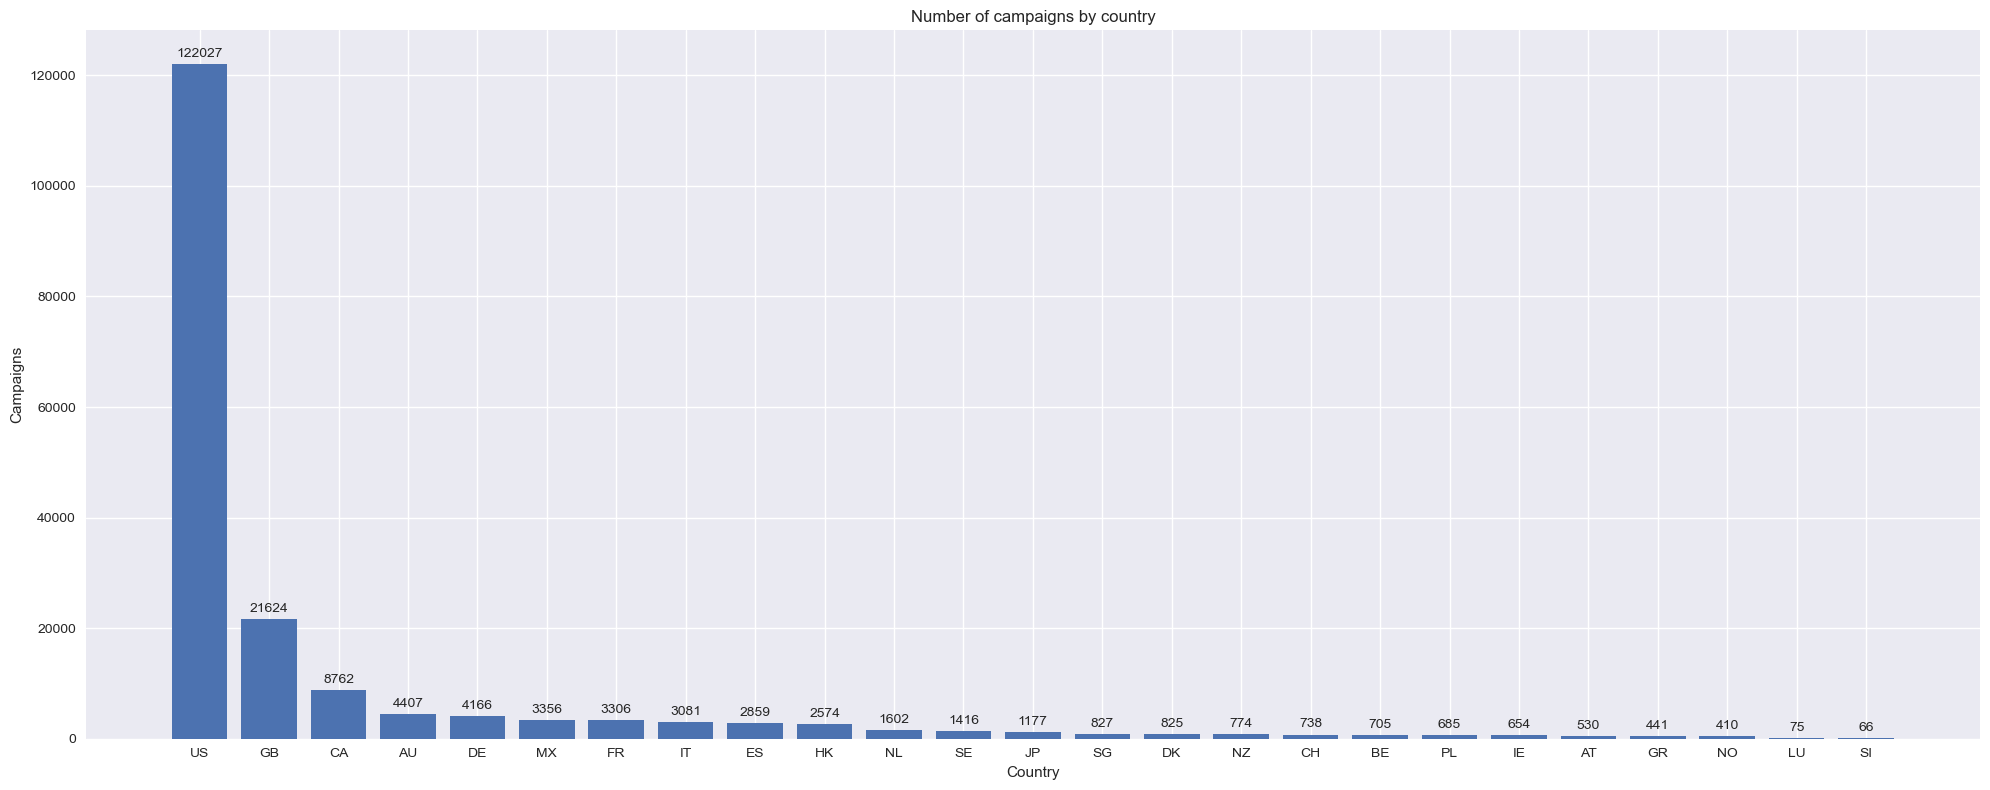

In [21]:
country_count = data['country'].value_counts()
fig, ax = plt.subplots(figsize=(20,8))
country_bars = ax.bar(country_count.index,country_count)
for bar in country_bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom')

ax.set_xlabel('Country')
ax.set_ylabel('Campaigns')
ax.set_title('Number of campaigns by country')

fig.tight_layout()
plt.savefig('images/campaigns_by_country.jpg')
plt.show()

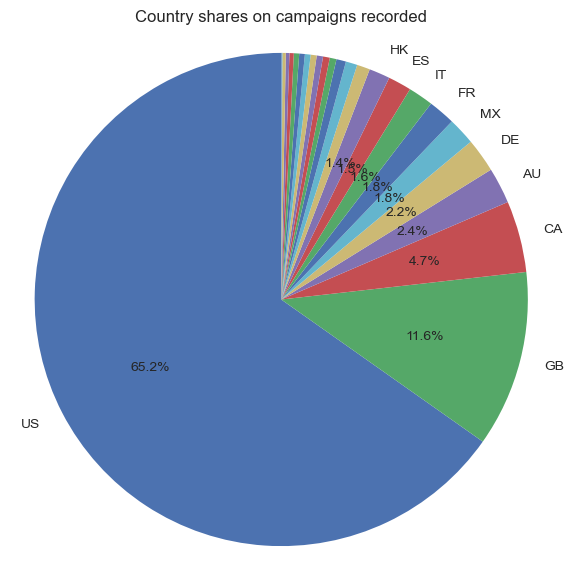

In [22]:
pct_threshold = 1
count_threshold = int(pct_threshold * data.shape[0] / 100.0)
last_country_idx = np.where(country_count > count_threshold)[0][-1]
country_above_pct_threshold = country_count.index.to_list()[:last_country_idx+1] + ['']*(len(country_count) - last_country_idx-1)

# Custom autopct function
def autopct_format(pct):
    return ('%.1f%%' % pct) if pct > pct_threshold else ''

# Create the pie chart
fig, ax = plt.subplots(figsize=(7,7))
ax.pie(country_count, labels=country_above_pct_threshold, autopct=autopct_format, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Country shares on campaigns recorded")
plt.savefig('images/campaigns_by_country_pie_chart.jpg')
plt.show()

# plt.pie(country_count, labels=country_count.index,startangle=90)

#### Country success rate

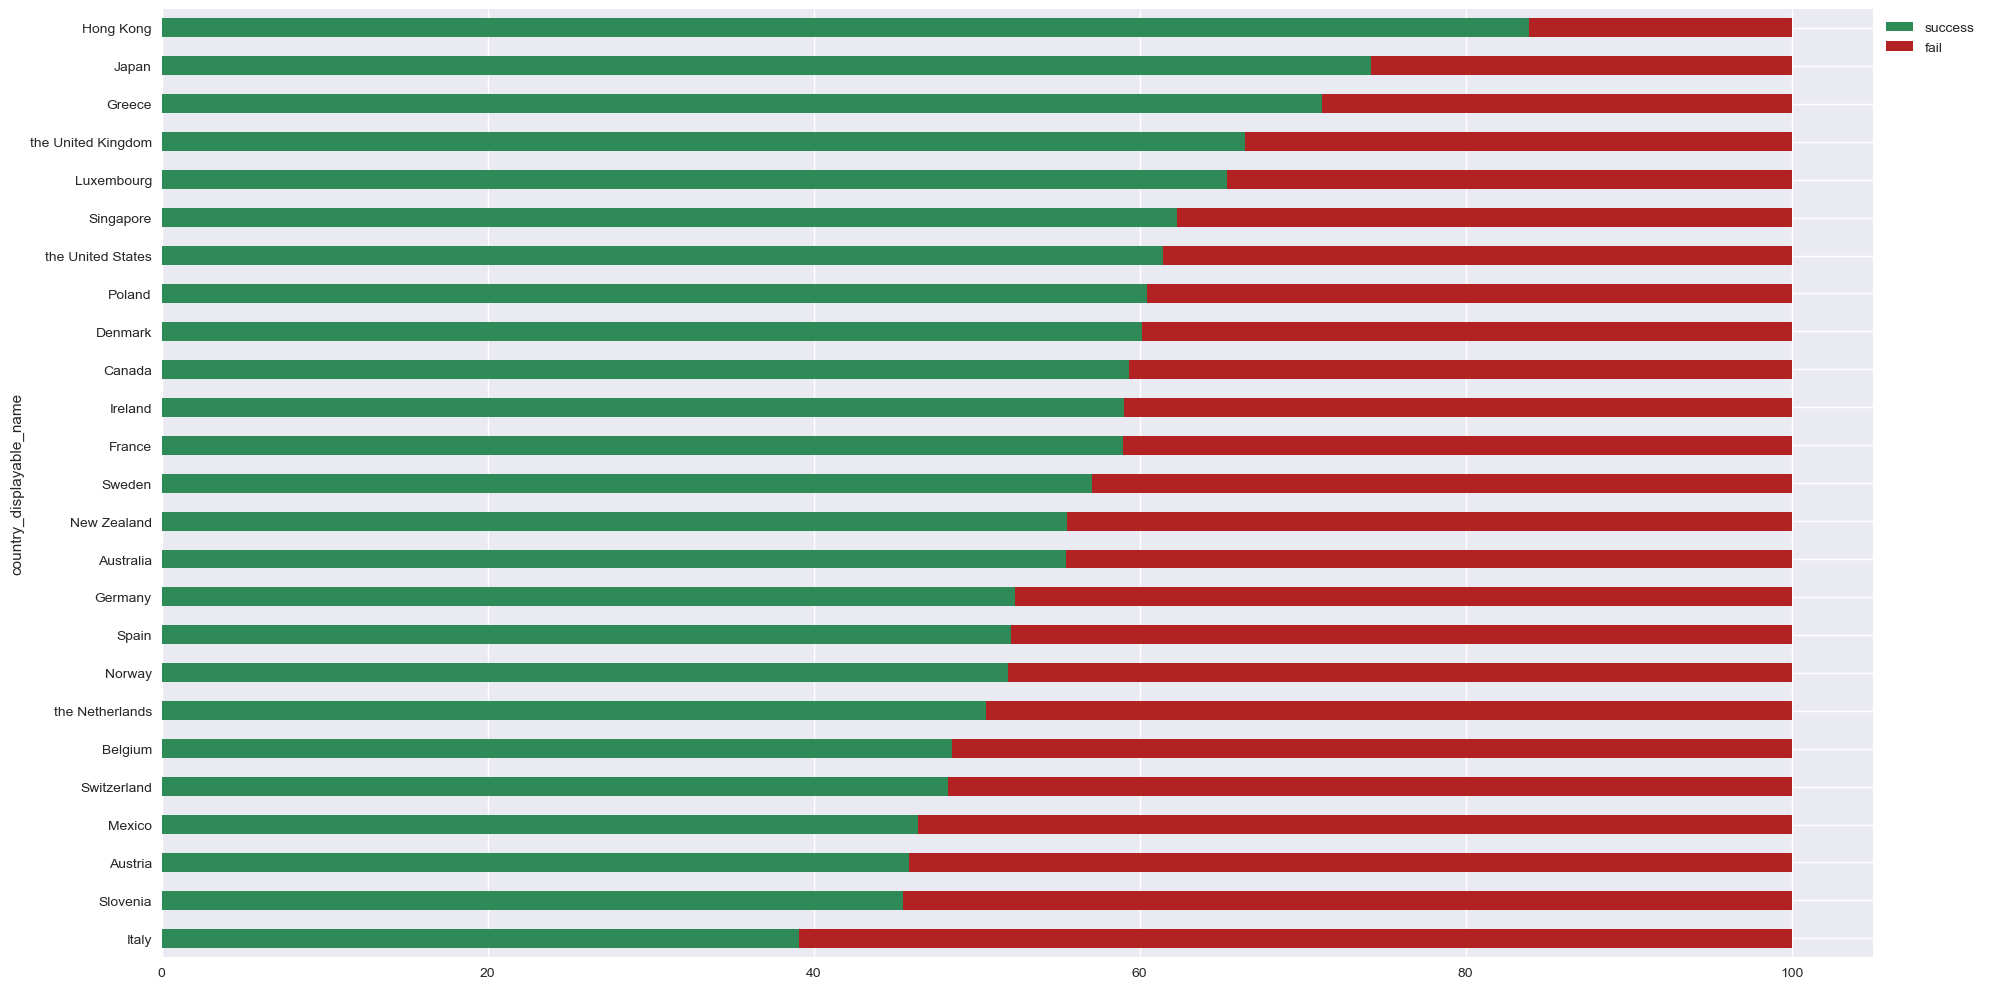

In [23]:
df3 = data[['country_displayable_name','state3']].groupby(by='country_displayable_name').mean().sort_values(by='state3')
df3['success'] = df3['state3']*100
df3['fail'] = 100-df3['success']
df3 = df3.drop(columns=['state3'])
# plot stacked horizontal bar chart for Success vs Fail percentage
ax = df3.plot(
    kind = 'barh', 
    stacked = True, 
    mark_right = True
    ,color = ['seagreen', 'firebrick']
    ,figsize=(20,10)
).legend(bbox_to_anchor=(1,1))
# ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig('images/country_success_rate.jpg')
plt.show()

## 3.2 Checking campaigns by datetime

#### Number of campaigns by year

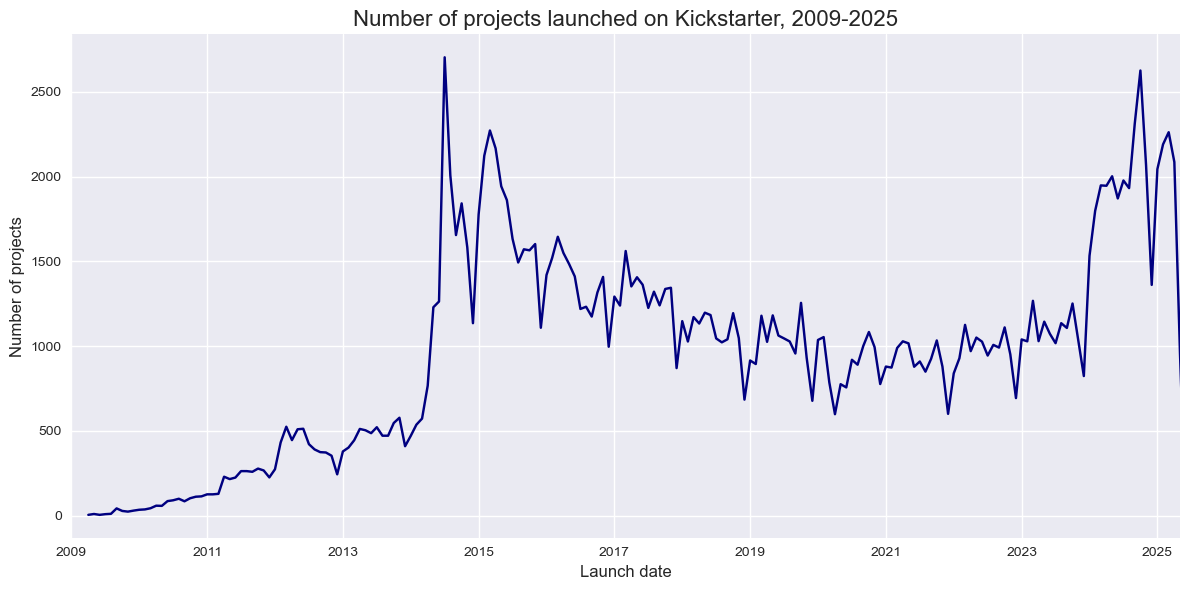

In [24]:
launched_year = data[['launched_at_datetime', 'has_video']].set_index('launched_at_datetime')\
                        .has_video.resample('M').count().plot(figsize=(12,6), color='navy')
plt.xlim('2009-01-01', '2025-05-30') # Limiting to whole months
plt.xlabel('Launch date', fontsize=12)
plt.ylabel('Number of projects', fontsize=12)
plt.title('Number of projects launched on Kickstarter, 2009-2025', fontsize=16)
plt.tight_layout()
plt.savefig('images/campaigns_by_year.jpg')
plt.show()

#### Number of campaigns by months

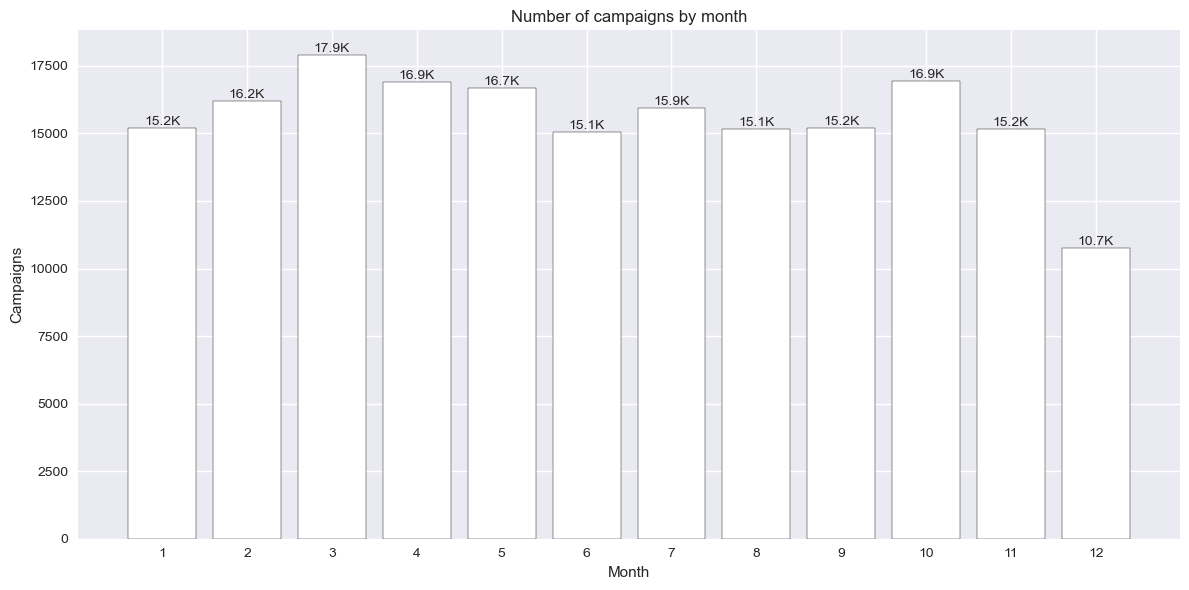

In [25]:
launched_month = data['launched_month'].value_counts().reset_index()
launched_month.sort_values(by='launched_month', inplace=True)

fig, ax = plt.subplots(figsize=(12,6))
bars = ax.bar(launched_month['launched_month'], launched_month['count'], facecolor='white', edgecolor='black')

for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, h, f'{(h/1000.0):.1f}K', ha='center', va='bottom')

# plt.xticks(rotation=90)
ax.set_xlabel('Month')
ax.set_xticks(launched_month['launched_month'].tolist())
ax.set_ylabel('Campaigns')
ax.set_title('Number of campaigns by month')
plt.tight_layout()
plt.savefig('images/campaigns_by_month.jpg')
plt.show()

#### Number of campaigns by weekdays

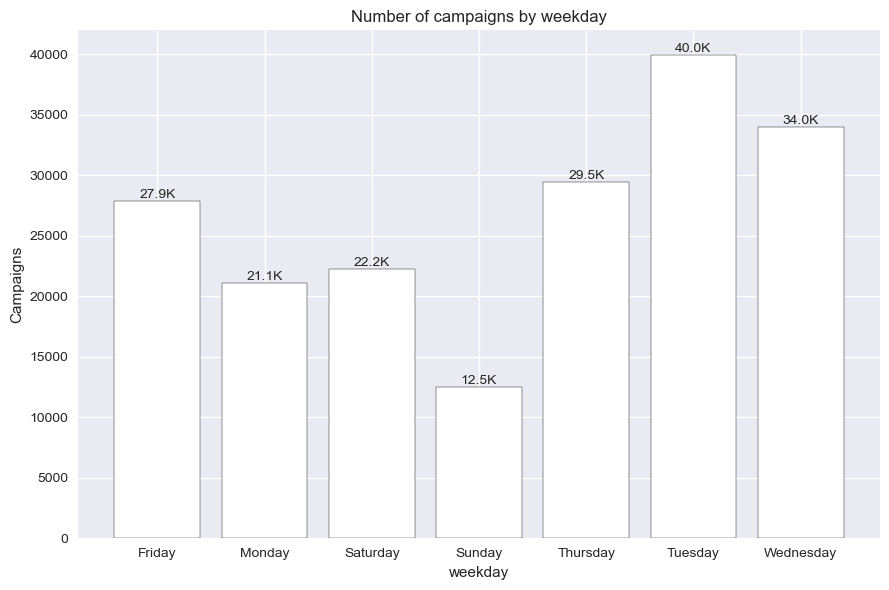

In [26]:
launched_weekday = data['launched_weekday'].value_counts().reset_index()
launched_weekday.sort_values(by='launched_weekday', inplace=True)

fig, ax = plt.subplots(figsize=(9,6))
bars = ax.bar(launched_weekday['launched_weekday'], launched_weekday['count'], facecolor='white', edgecolor='black')

for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, h, f'{(h/1000.0):.1f}K', ha='center', va='bottom')

# plt.xticks(rotation=90)
ax.set_xlabel('weekday')
ax.set_xticks(launched_weekday['launched_weekday'].tolist())
ax.set_ylabel('Campaigns')
ax.set_title('Number of campaigns by weekday')
plt.tight_layout()
plt.savefig('images/campaigns_by_weekday.jpg')
plt.show()

#### Yearly success rate

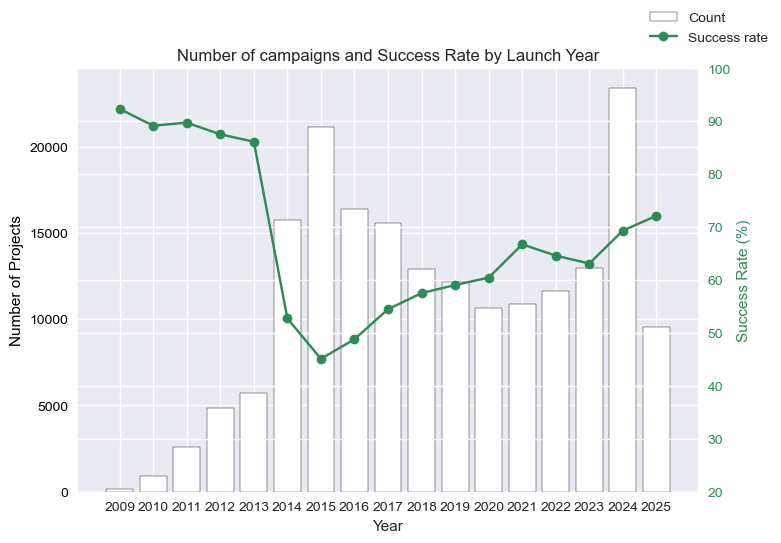

In [27]:
# group by launch year to get success rate per year
df_year = data[['launched_year','state3']].groupby(by='launched_year').mean().sort_values(by='launched_year')
df_year['success'] = df_year['state3']*100

# group by launch year to get number of projects per year 
temp = data.groupby(by='launched_year').size().reset_index(name='total_count')
df_year = pd.merge(df_year,temp,how='left',on='launched_year')

# plot both success rate and number of projects
# Create the figure and axes
fig, ax1 = plt.subplots()

# Bar plot for number of projects
ax1.bar(df_year['launched_year'], df_year['total_count'], facecolor='white', edgecolor='black', label='Count')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Projects', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for success rate
ax2 = ax1.twinx()

# Line plot for success rate
ax2.plot(df_year['launched_year'], df_year['success'], color='seagreen', marker='o', label='Success rate')
ax2.set_ylabel('Success Rate (%)', color='seagreen')
ax2.set_xticks(df_year['launched_year'])
ax2.set_ylim([20,100])
ax2.tick_params(axis='y', labelcolor='seagreen')

# Add legend
fig.legend()
# plt.tight_layout()
# Display the plot
plt.title('Number of campaigns and Success Rate by Launch Year')
plt.savefig('images/success_rate_by_year.jpg')
plt.show()

#### Monthly success rate

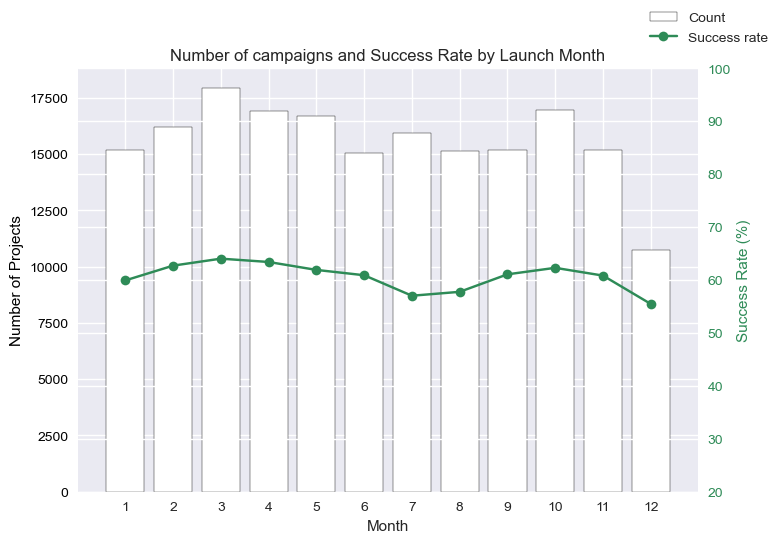

In [28]:
# group by launch year to get success rate per month
df3 = data[['launched_month','state3']].groupby(by='launched_month').mean().sort_values(by='launched_month')
df3['success'] = df3['state3']*100

# group by launch year to get number of projects per year 
temp = data.groupby(by='launched_month').size().reset_index(name='total_count')
df3 = pd.merge(df3,temp,how='left',on='launched_month')

# plot both success rate and number of projects
# Create the figure and axes
fig, ax1 = plt.subplots()

# Bar plot for number of projects
ax1.bar(df3['launched_month'], df3['total_count'], facecolor='white', edgecolor='black', label='Count')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Projects', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for success rate
ax2 = ax1.twinx()

# Line plot for success rate
ax2.plot(df3['launched_month'], df3['success'], color='seagreen', marker='o', label='Success rate')
ax2.set_ylabel('Success Rate (%)', color='seagreen')
ax2.set_xticks(df3['launched_month'])
ax2.set_ylim([20,100])
ax2.tick_params(axis='y', labelcolor='seagreen')

# Add legend
fig.legend()

# Display the plot
plt.title('Number of campaigns and Success Rate by Launch Month')
plt.savefig('images/success_rate_number_of_campaigns_by_month.jpg')
plt.show()

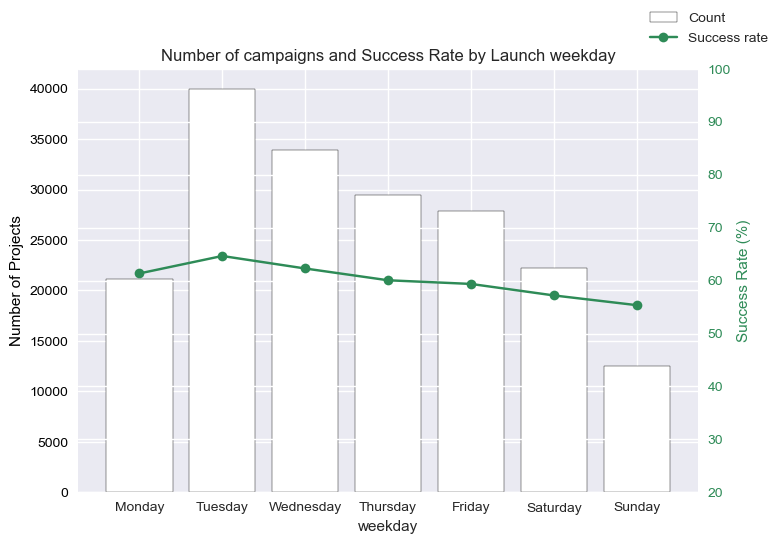

In [29]:
# group by launch year to get success rate per month
df3 = data[['launched_weekday','state3', 'launched_weekday_number']].groupby(by='launched_weekday').mean().sort_values(by='launched_weekday_number')
df3['success'] = df3['state3']*100

# group by launch year to get number of projects per year 
temp = data.groupby(by='launched_weekday').size().reset_index(name='total_count')
df3 = pd.merge(df3,temp,how='left',on='launched_weekday')

# plot both success rate and number of projects
# Create the figure and axes
fig, ax1 = plt.subplots()

# Bar plot for number of projects
ax1.bar(df3['launched_weekday'], df3['total_count'], facecolor='white', edgecolor='black', label='Count')
ax1.set_xlabel('weekday')
ax1.set_ylabel('Number of Projects', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for success rate
ax2 = ax1.twinx()

# Line plot for success rate
ax2.plot(df3['launched_weekday'], df3['success'], color='seagreen', marker='o', label='Success rate')
ax2.set_ylabel('Success Rate (%)', color='seagreen')
ax2.set_xticks(df3['launched_weekday'])
ax2.set_ylim([20,100])
ax2.tick_params(axis='y', labelcolor='seagreen')

# Add legend
fig.legend()

# Display the plot
plt.title('Number of campaigns and Success Rate by Launch weekday')
plt.savefig('images/success_rate_number_of_campaigns_by_weekday.jpg')
plt.show()

#### Pledged and Goal amount by year

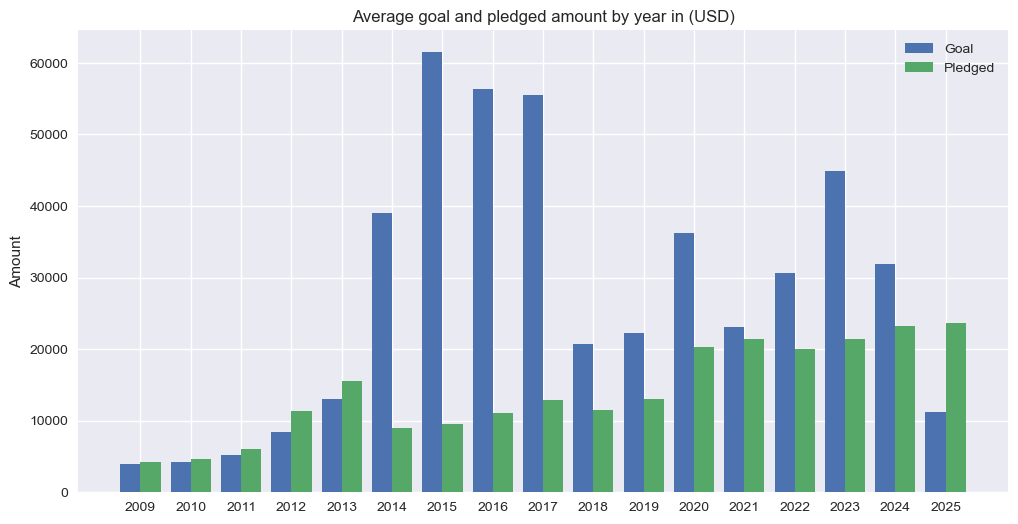

In [30]:
df3 = data.groupby('launched_year') \
            .agg({'usd_goal': 'mean', 'usd_pledged':'mean'})

width = 0.4
x = np.arange(df3.shape[0])
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width/2, df3['usd_goal'], width, label='Goal')
ax.bar(x + width/2, df3['usd_pledged'], width, label='Pledged')

ax.set_xticks(x, df3.index)
# plt.xticks(rotation=60)
ax.set_ylabel('Amount')
ax.set_title('Average goal and pledged amount by year in (USD)')
ax.legend()
plt.savefig('images/average_goal_and_pledged_amount_by_year.jpg')
plt.show()

## 3.3 Checking campaigns by main category

#### Main Category success rate

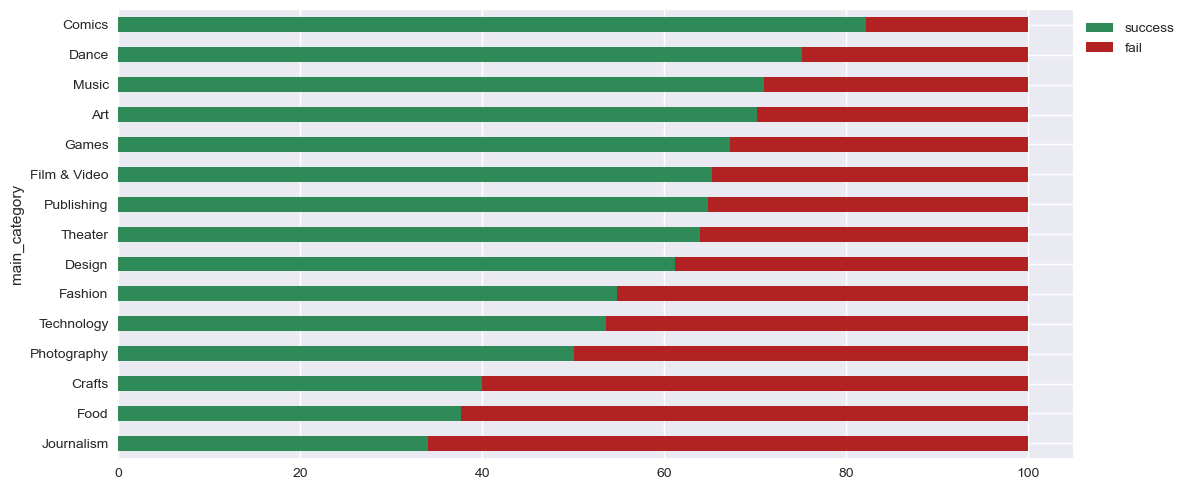

In [31]:
df3 = data[['main_category','state3']].groupby(by='main_category').mean().sort_values(by='state3')
df3['success'] = df3['state3']*100
df3['fail'] = 100-df3['success']
df3 = df3.drop(columns=['state3'])
# plot stacked horizontal bar chart for Success vs Fail percentage
ax = df3.plot(
    kind = 'barh', 
    stacked = True, 
    mark_right = True
    ,color = ['seagreen', 'firebrick']
    ,figsize=(12,5)
).legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig('images/main_category_success_rate.jpg')
plt.show()

#### Pledged and Goal amount by main category

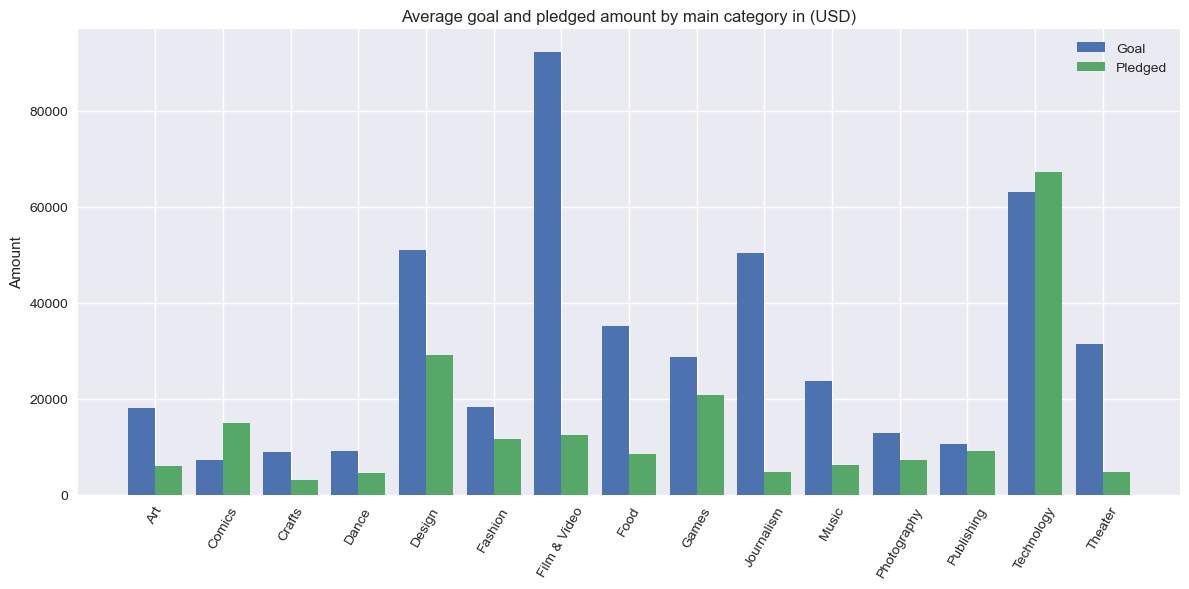

In [32]:
df3 = data.groupby('main_category') \
            .agg({'usd_goal': 'mean', 'usd_pledged':'mean'})

width = 0.4
x = np.arange(df3.shape[0])
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width/2, df3['usd_goal'], width, label='Goal')
ax.bar(x + width/2, df3['usd_pledged'], width, label='Pledged')

ax.set_xticks(x, df3.index)
plt.xticks(rotation=60)
ax.set_ylabel('Amount')
ax.set_title('Average goal and pledged amount by main category in (USD)')
ax.legend()
plt.tight_layout()
plt.savefig('images/average_goal_and_pledged_amount_by_main_category.jpg')
plt.show()

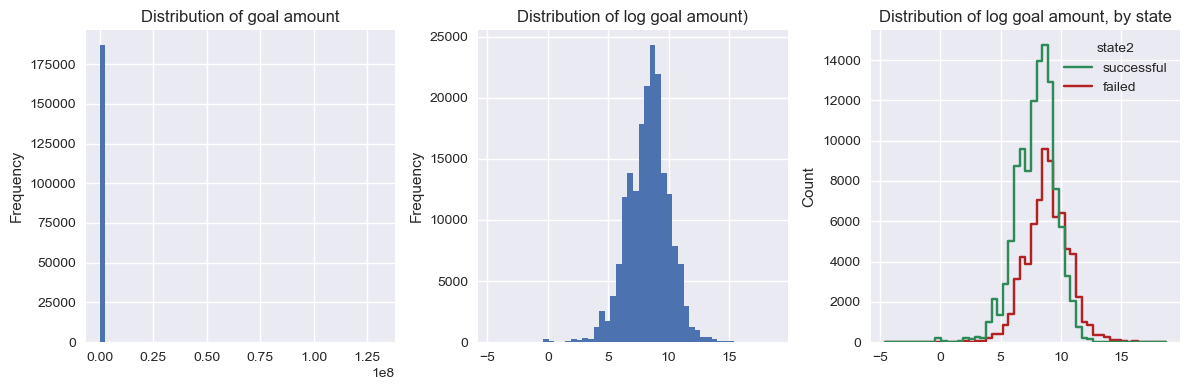

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

data['usd_goal'].plot.hist(bins=50, ax=ax1)
ax1.set_title('Distribution of goal amount')
ax1.set_xlabel('')

data['log_usd_goal'].plot.hist(bins=50, ax=ax2)
ax2.set_title('Distribution of log goal amount)')
ax2.set_xlabel('')

dax3 = data[['state2', 'log_usd_goal']]
sns.histplot(data=dax3, x='log_usd_goal', hue='state2', bins = 50, ax=ax3
             , element="step", palette={'successful': 'seagreen', 'failed': 'firebrick'}, alpha=1, fill=False, legend=True)
ax3.set_title('Distribution of log goal amount, by state')
ax3.set_xlabel('')
plt.tight_layout()
plt.savefig('images/USD goal distributions.jpg')
plt.show()

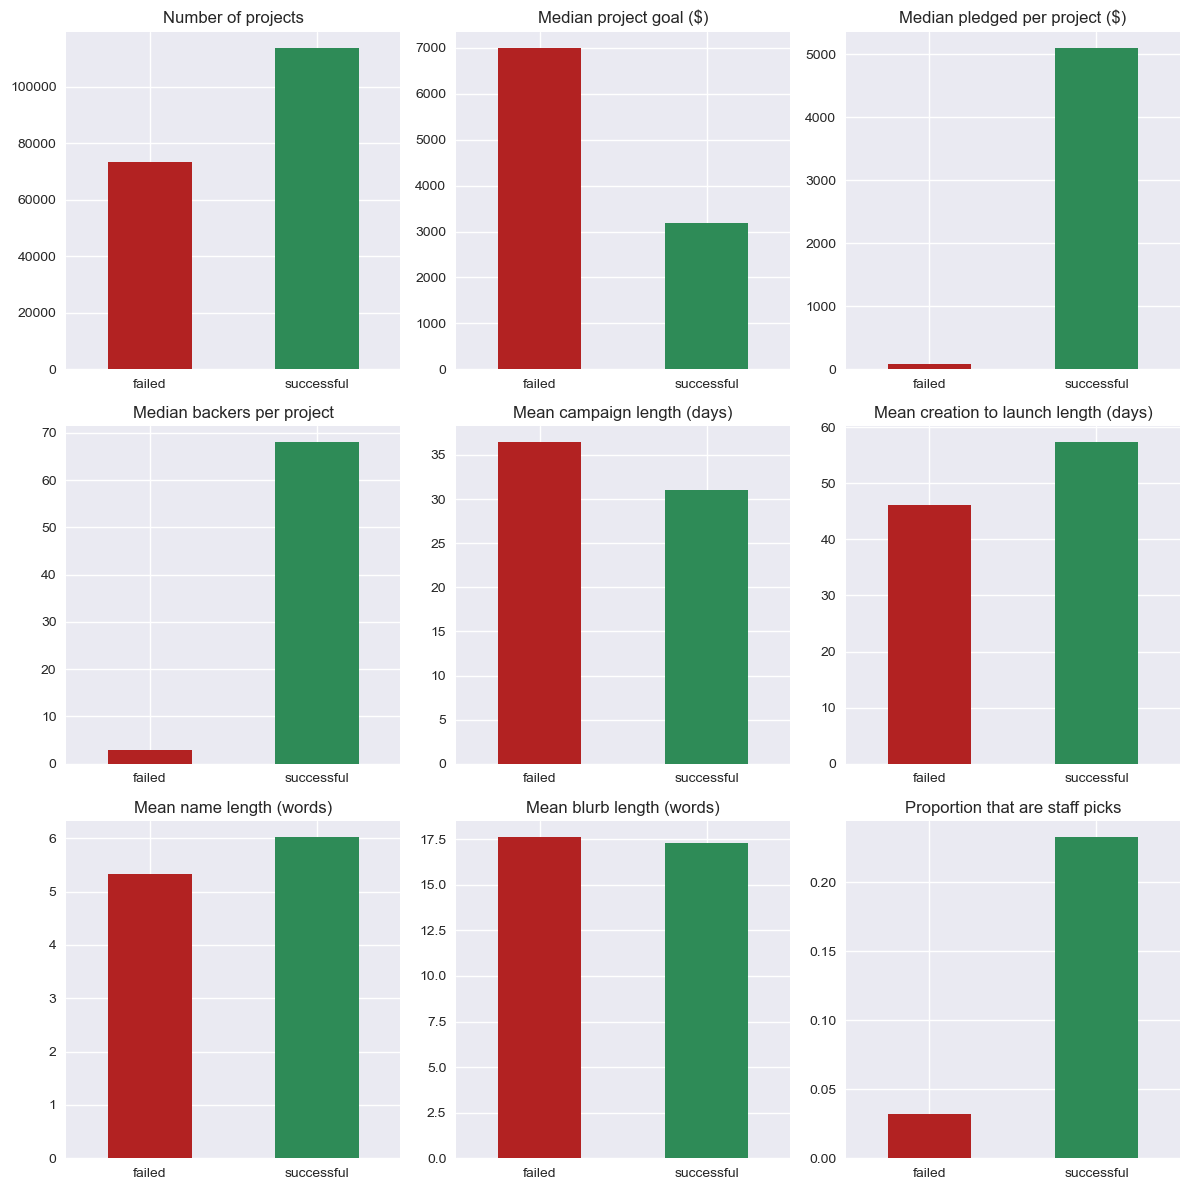

In [34]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12,12))

data['state2'].value_counts(ascending=True).plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'], rot=0)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

data.groupby('state2').usd_goal.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'], rot=0)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

data.groupby('state2').converted_pledged_amount.median().plot(kind='bar', ax=ax3, color=['firebrick', 'seagreen'], rot=0)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

data.groupby('state2').backers_count.median().plot(kind='bar', ax=ax4, color=['firebrick', 'seagreen'], rot=0)
ax4.set_title('Median backers per project')
ax4.set_xlabel('')

data.groupby('state2').duration.mean().plot(kind='bar', ax=ax5, color=['firebrick', 'seagreen'], rot=0)
ax5.set_title('Mean campaign length (days)')
ax5.set_xlabel('')

data.groupby('state2').pre_launch_time.mean().plot(kind='bar', ax=ax6, color=['firebrick', 'seagreen'], rot=0)
ax6.set_title('Mean creation to launch length (days)')
ax6.set_xlabel('')

data.groupby('state2').num_words_name.mean().plot(kind='bar', ax=ax7, color=['firebrick', 'seagreen'], rot=0)
ax7.set_title('Mean name length (words)')
ax7.set_xlabel('')

data.groupby('state2').num_words_blurb.mean().plot(kind='bar', ax=ax8, color=['firebrick', 'seagreen'], rot=0)
ax8.set_title('Mean blurb length (words)')
ax8.set_xlabel('')

# Creating a dataframe grouped by staff_pick with columns for failed and successful
pick_df = pd.get_dummies(data.set_index('staff_pick').state2).groupby('staff_pick').sum()
# Normalizes counts by column, and selects the 'True' category (iloc[1])
(pick_df.div(pick_df.sum(axis=0), axis=1)).iloc[1].plot(kind='bar', ax=ax9, color=['firebrick', 'seagreen'], rot=0) 
ax9.set_title('Proportion that are staff picks')
ax9.set_xlabel('')

fig.subplots_adjust(hspace=0.3)
plt.tight_layout()
fig.savefig('images/state_comparison.jpg')
plt.show()

#### Compare distributions of backer counts and video usage across successful vs. failed campaigns.

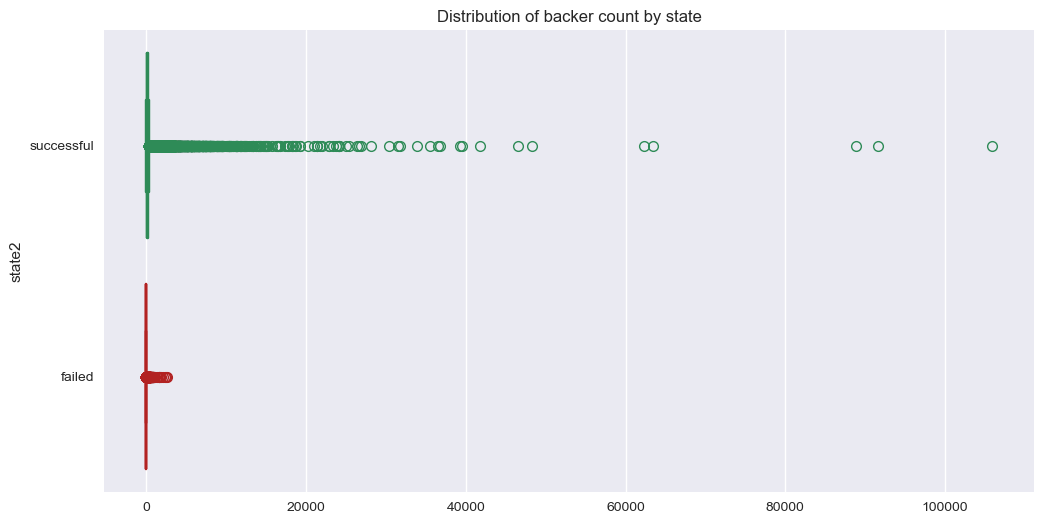

In [35]:
fig, ax1 = plt.subplots(1,1, figsize=(12,6))

d1 = data[['state2', 'backers_count']]
# sns.histplot(data=d1, x='backers_count', hue='state2', bins = 50, ax=ax1
#              , element="step", palette={'successful': 'seagreen', 'failed': 'firebrick'}, alpha=1, fill=False, legend=True)
sns.boxplot(data=d1, x='backers_count', y='state2', ax=ax1
             , palette={'successful': 'seagreen', 'failed': 'firebrick'}, fill=False, legend=True)
ax1.set_title('Distribution of backer count by state')
ax1.set_xlabel('')
'''
d2 = data[['has_video','state3']].groupby(by='has_video').mean().sort_values(by='state3')
d2['success'] = d2['state3']*100
d2['fail'] = 100-d2['success']
d2 = d2.drop(columns=['state3'])
# plot stacked horizontal bar chart for Success vs Fail percentage
ax2 = d2.plot(
    kind = 'barh', 
    stacked = True, 
    mark_right = True
    ,color = ['seagreen', 'firebrick']
).legend(bbox_to_anchor=(1,1))
plt.savefig('images/backers_count_distribution_has_video_success_rate.jpg')
'''
plt.show()

In [36]:
data[data['backers_count'] > 100000]['usd_pledged']

66048    5408916.95
Name: usd_pledged, dtype: float64

## 3.4 Text data analysis

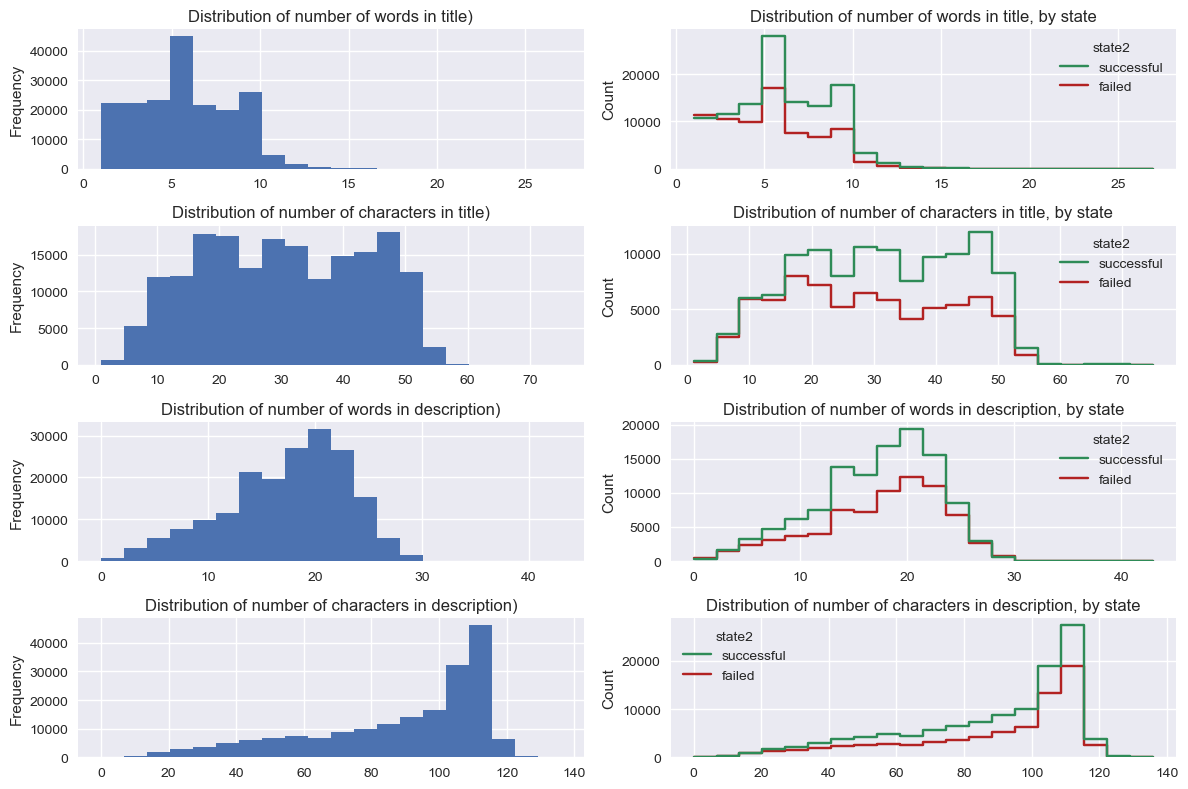

In [37]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(12,8))

data['num_words_name'].plot.hist(bins=20, ax=ax1)
ax1.set_title('Distribution of number of words in title)')
ax1.set_xlabel('')

d1 = data[['state2', 'num_words_name']]
sns.histplot(data=d1, x='num_words_name', hue='state2', bins = 20, ax=ax2
             , element="step", palette={'successful': 'seagreen', 'failed': 'firebrick'}, alpha=1, fill=False, legend=True)
ax2.set_title('Distribution of number of words in title, by state')
ax2.set_xlabel('')

data['num_chars_name'].plot.hist(bins=20, ax=ax3)
ax3.set_title('Distribution of number of characters in title)')
ax3.set_xlabel('')

d2 = data[['state2', 'num_chars_name']]
sns.histplot(data=d2, x='num_chars_name', hue='state2', bins = 20, ax=ax4
             , element="step", palette={'successful': 'seagreen', 'failed': 'firebrick'}, alpha=1, fill=False, legend=True)
ax4.set_title('Distribution of number of characters in title, by state')
ax4.set_xlabel('')

data['num_words_blurb'].plot.hist(bins=20, ax=ax5)
ax5.set_title('Distribution of number of words in description)')
ax5.set_xlabel('')

d3 = data[['state2', 'num_words_blurb']]
sns.histplot(data=d3, x='num_words_blurb', hue='state2', bins = 20, ax=ax6
             , element="step", palette={'successful': 'seagreen', 'failed': 'firebrick'}, alpha=1, fill=False, legend=True)
ax6.set_title('Distribution of number of words in description, by state')
ax6.set_xlabel('')

data['num_chars_blurb'].plot.hist(bins=20, ax=ax7)
ax7.set_title('Distribution of number of characters in description)')
ax7.set_xlabel('')

d4 = data[['state2', 'num_chars_blurb']]
sns.histplot(data=d4, x='num_chars_blurb', hue='state2', bins = 20, ax=ax8
             , element="step", palette={'successful': 'seagreen', 'failed': 'firebrick'}, alpha=1, fill=False, legend=True)
ax8.set_title('Distribution of number of characters in description, by state')
ax8.set_xlabel('')


# data[['num_words_name', 'num_chars_name', 'num_words_blurb', 'num_chars_blurb']].hist(bins=20, figsize=(12,10))
plt.tight_layout()
plt.savefig('images/number_of_words_and_characters_in_title_and_description.jpg')
plt.show()

# 4. Feature selection

In [38]:
# list of columns to use
'''
'backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'country_displayable_name', 'created_at', 'creator',
       'currency', 'currency_symbol', 'currency_trailing_code',
       'current_currency', 'deadline', 'disable_communication', 'fx_rate',
       'goal', 'id', 'is_disliked', 'is_in_post_campaign_pledging_phase',
       'is_launched', 'is_liked', 'is_starrable', 'launched_at', 'location',
       'name', 'percent_funded', 'photo', 'pledged', 'prelaunch_activated',
       'profile', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'urls', 'usd_exchange_rate',
       'usd_pledged', 'usd_type', 'video', 'file_source',
       'created_at_datetime', 'launched_at_datetime', 'deadline_datetime',
       'launched_year', 'launched_month', 'launched_month_name',
       'launched_week', 'launched_weekday', 'launched_is_weekend',
       'pre_launch_time', 'quarter', 'q1', 'q2', 'q3', 'q4', 'duration',
       'state2', 'state3', 'main_category', 'sub_category', 'main_category_id',
       'sub_category_id', 'mean_main_category_goal', 'main_category_count',
       'mean_sub_category_goal', 'sub_category_count', 'Art', 'Comics',
       'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video', 'Food', 'Games',
       'Journalism', 'Music', 'Photography', 'Publishing', 'Technology',
       'Theater', 'num_words_name', 'num_chars_name', 'num_words_blurb',
       'num_chars_blurb', 'has_video', 'usd_goal', 'log_usd_goal'
'''
categorical_columns = ['launched_month', 'launched_weekday', 'launched_is_weekend','quarter','main_category', 'sub_category','has_video']
numerical_columns = ['pre_launch_time','duration','mean_main_category_goal', 'main_category_count','mean_sub_category_goal', 'sub_category_count'
                    ,'num_words_name', 'num_chars_name', 'num_words_blurb', 'num_chars_blurb', 'usd_goal', 'log_usd_goal']
column_for_testing = categorical_columns + numerical_columns

## 4.1 Chi-square test for categorical data

Select the top k categorical values, which means that they affect the outcome the most

In [39]:
# creating a contingency table between category and state of project
# Loading wine data
X = data[['launched_at_datetime', 'launched_month',
       'launched_is_weekend', 'quarter', 'q1', 'q2', 'q3',
       'q4', 'main_category_id', 'sub_category_id',
       'Art', 'Comics', 'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video', 'Food', 'Games',
       'Journalism', 'Music', 'Photography', 'Publishing', 'Technology',
       'Theater', 'has_video']]
X['launched_weekday'] = X['launched_at_datetime'].dt.weekday
X.drop(columns=['launched_at_datetime'], inplace=True)
y = data['state3']
# X,y=datasets.load_wine(return_X_y=True)
# k = 4 tells four top features to be selected
# Score function Chi2 tells the feature to be selected using Chi Square
chi2_test = SelectKBest(score_func=chi2, k=10)
fit = chi2_test.fit(X, y)
print(fit.scores_)
X_new=chi2_test.fit_transform(X, y)

[1.83661724e+02 2.68964226e+02 5.41651935e+01 4.64595451e+01
 3.35217917e+01 9.71348794e+01 1.04824725e+01 3.60829190e+03
 1.81456076e+06 6.14860957e+02 1.20560073e+03 1.39818127e+03
 2.75314896e+02 5.82646741e-01 1.60533460e+02 2.15380182e+02
 3.45320200e+03 2.18878266e+02 1.35243541e+03 1.11361836e+03
 3.23978046e+02 1.33592323e+02 3.82411757e+02 2.58113128e+01
 2.34483742e+03 5.36591472e+02]


In [40]:
chi2_test.get_feature_names_out()

array(['main_category_id', 'sub_category_id', 'Art', 'Comics', 'Crafts',
       'Food', 'Journalism', 'Music', 'has_video', 'launched_weekday'],
      dtype=object)

## 4.2 Tree’s Feature Importance from Mean Decrease in Impurity (MDI)

In [41]:
X = data[column_for_testing]
y = data['state3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=6740)

In [42]:
def train_rf(clf, X_train, y_train, categorical_columns, numerical_columns):
    categorical_encoder = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
    )
    numerical_pipe = SimpleImputer(strategy="mean")
    
    preprocessing = ColumnTransformer(
        [
            ("cat", categorical_encoder, categorical_columns),
            ("num", numerical_pipe, numerical_columns),
        ],
        verbose_feature_names_out=False,
    )
    
    clf2 = Pipeline(
        [
            ("preprocess", preprocessing),
            ("classifier", clf),
        ]
    )
    clf2.fit(X_train, y_train)
    return clf2

def plot_MDI(rf, ax, title = '', save=0, save_name = ''):
    rf_feature_names = rf[:-1].get_feature_names_out()
    mdi_importances = pd.Series(
        rf[-1].feature_importances_, index=rf_feature_names
    ).sort_values(ascending=True)
    mdi_importances.plot.barh(ax=ax)
    ax.set_title(title)
    ax.figure.tight_layout()
    if save:
        plt.savefig(save_name)
    # plt.show()

def get_permutation_importance(rf, X, y):
    result = permutation_importance(
        rf, X, y, n_repeats=10, random_state=6740, n_jobs=2
    )
    
    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    return importances

# split into 2 functions for better control
def plot_permutation_importance(importances, ax, title='', save=0, save_name=''):
    importances.plot.box(vert=False, whis=10, ax=ax)
    ax.set_title(title)
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()

    if save:
        plt.savefig(save_name)
    # plt.show()

In [43]:
rf = RandomForestClassifier(random_state=6740)
rf_basic = train_rf(rf, X_train, y_train, categorical_columns, numerical_columns)
print(f"RF train accuracy: {rf_basic.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf_basic.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.786


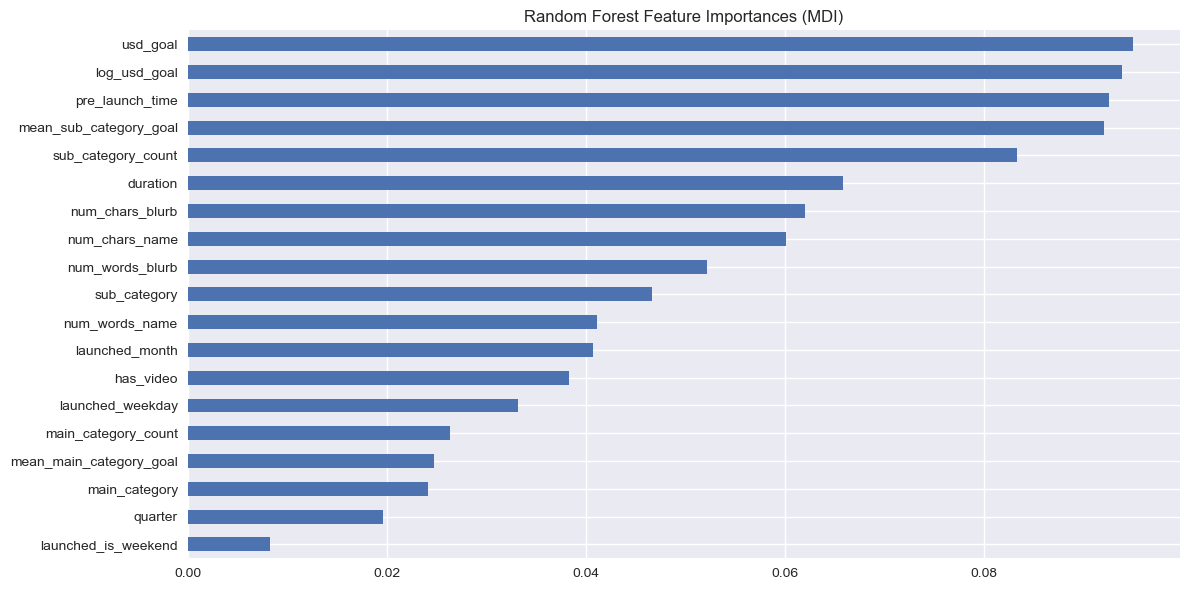

In [44]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
plot_MDI(rf_basic, ax, title="Random Forest Feature Importances (MDI)")
plt.tight_layout()
plt.savefig('images/rf1_MDI.jpg')

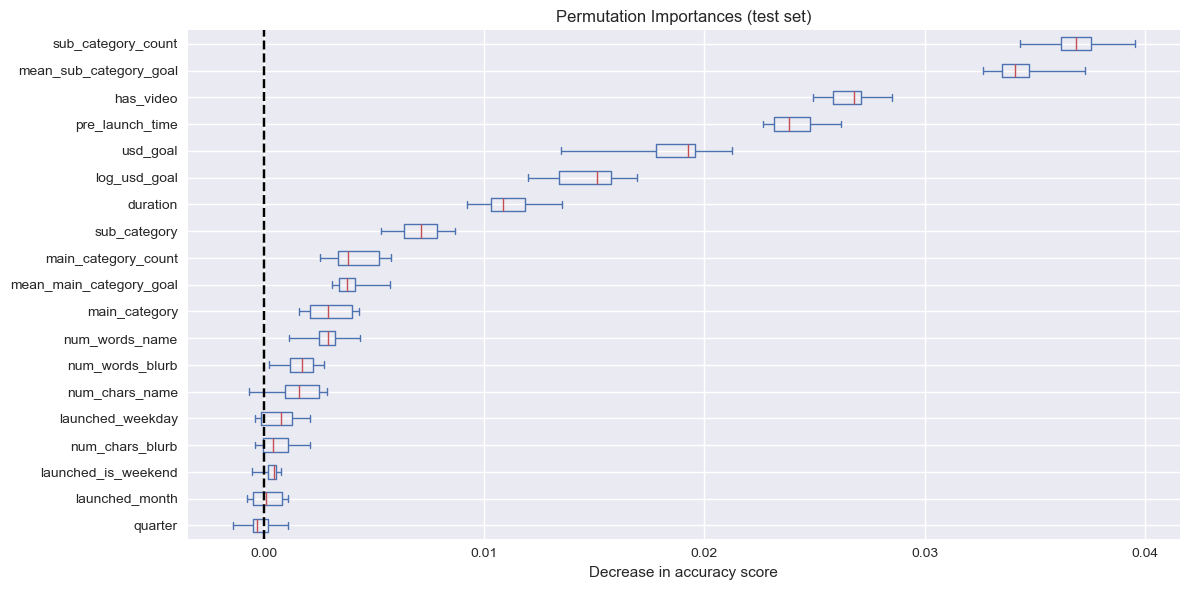

In [45]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
importances = get_permutation_importance(rf_basic, X_test, y_test)
plot_permutation_importance(importances, ax, title='Permutation Importances (test set)')
plt.tight_layout()
plt.savefig('images/rf1_permutation_test.jpg')

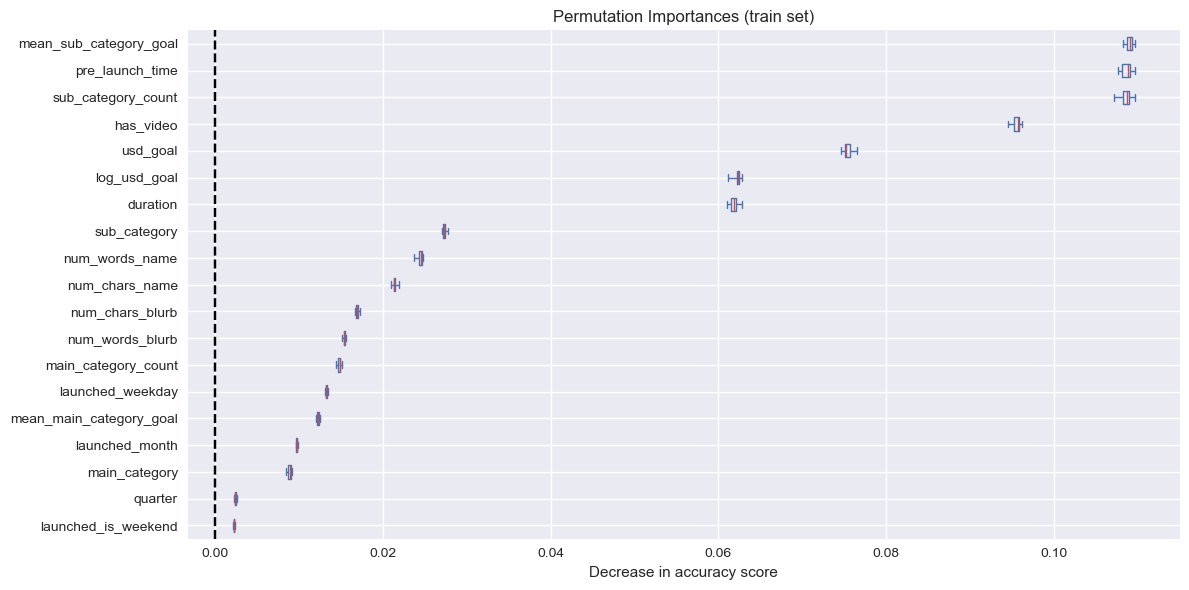

In [46]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
importances = get_permutation_importance(rf_basic, X_train, y_train)
plot_permutation_importance(importances, ax, title='Permutation Importances (train set)')
plt.tight_layout()
plt.savefig('images/rf1_permutation_train.jpg')

#### To prevent overfitting, set min_samples_leaf 20 data points

In [47]:
# rf.set_params(classifier__min_samples_leaf=20).fit(X_train, y_train)
rf = RandomForestClassifier(random_state=6740, min_samples_leaf=20)
rf_2 = train_rf(rf, X_train, y_train, categorical_columns, numerical_columns)
print(f"RF train accuracy: {rf_2.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf_2.score(X_test, y_test):.3f}")

RF train accuracy: 0.830
RF test accuracy: 0.787


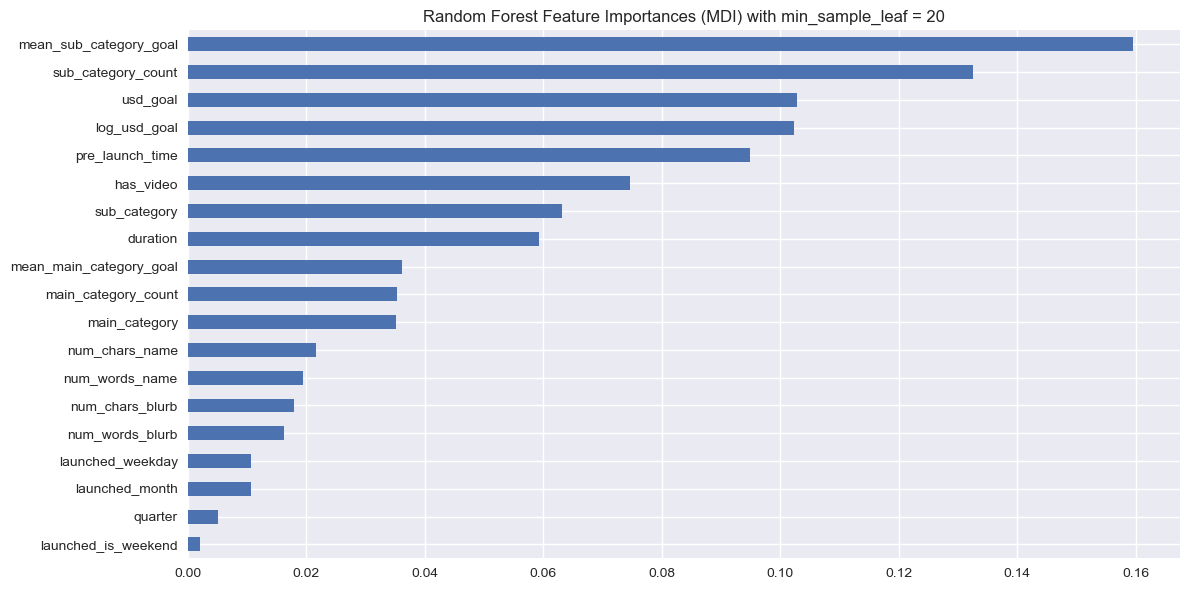

In [48]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
plot_MDI(rf_2, ax, title="Random Forest Feature Importances (MDI) with min_sample_leaf = 20")
plt.tight_layout()
plt.savefig('images/rf2_MDI.jpg')

In [49]:
importances_test = get_permutation_importance(rf_2, X_test, y_test)
# importances_train = get_permutation_importance(rf_2, X_train, y_train)

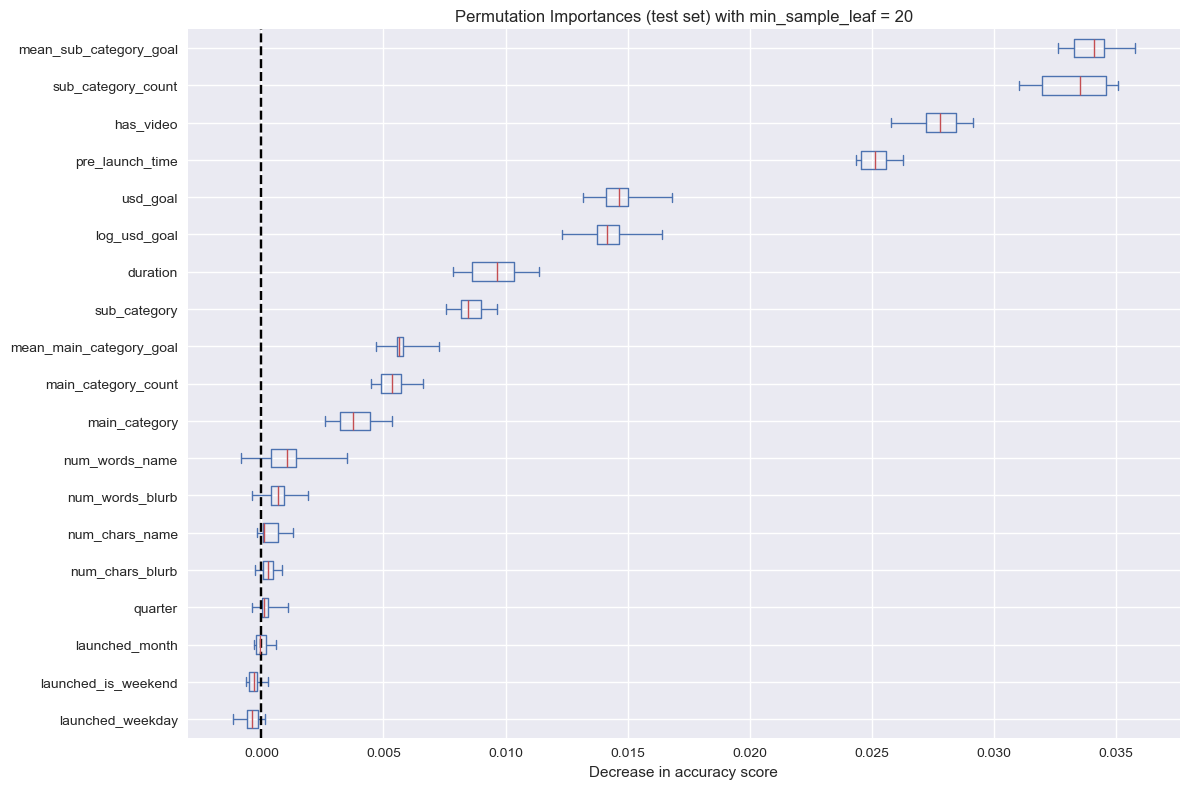

In [50]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
plot_permutation_importance(importances_test, ax, title='Permutation Importances (test set) with min_sample_leaf = 20')
# plot_permutation_importance(importances_train, ax2, title='Permutation Importances (train set) with min_sample_leaf = 20')
plt.tight_layout()
plt.savefig('images/rf2_permutation_test.jpg')

#### Impurity-based vs. permutation importances on multicollinear features

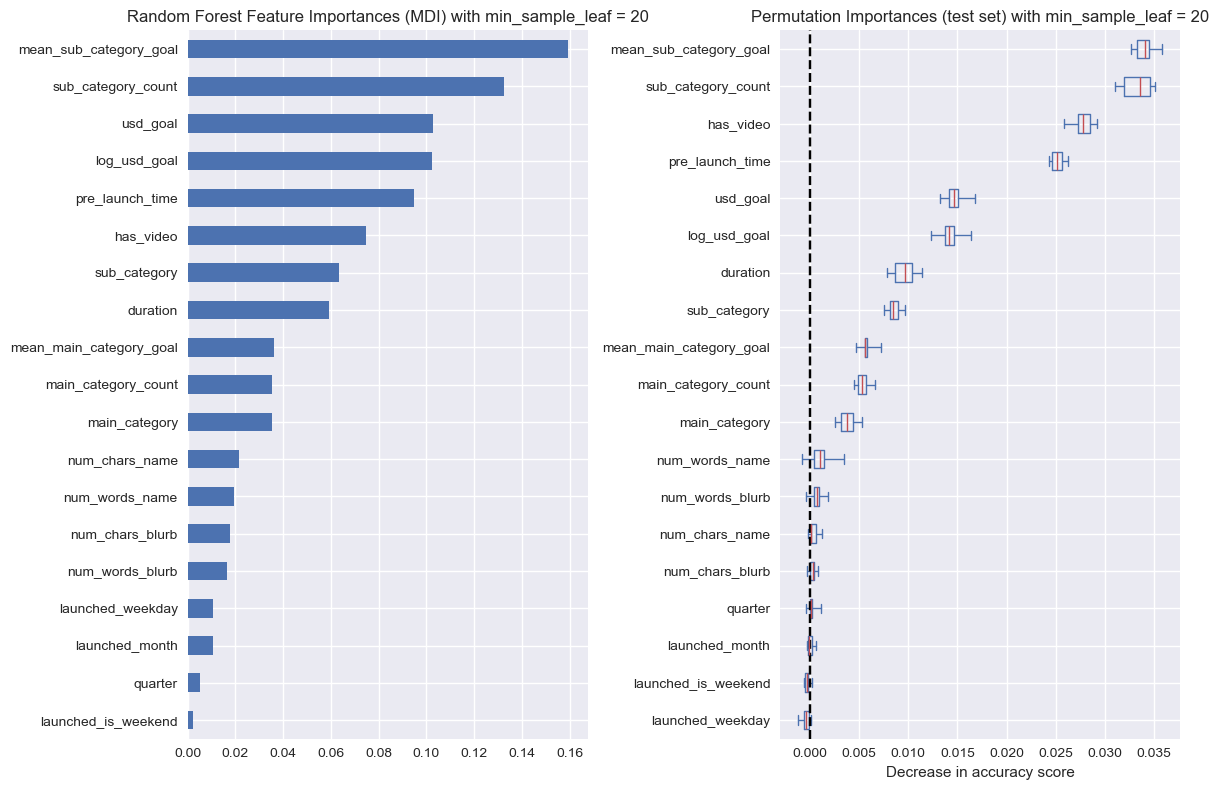

In [51]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
plot_MDI(rf_2, ax1, title="Random Forest Feature Importances (MDI) with min_sample_leaf = 20")
plot_permutation_importance(importances_test, ax2, title='Permutation Importances (test set) with min_sample_leaf = 20')
fig.tight_layout()
plt.savefig('images/rf2_MDI_permutation_test.jpg')
plt.show()

## 4.3 Handling Multicollinear Features

In [52]:
X.shape

(187087, 19)

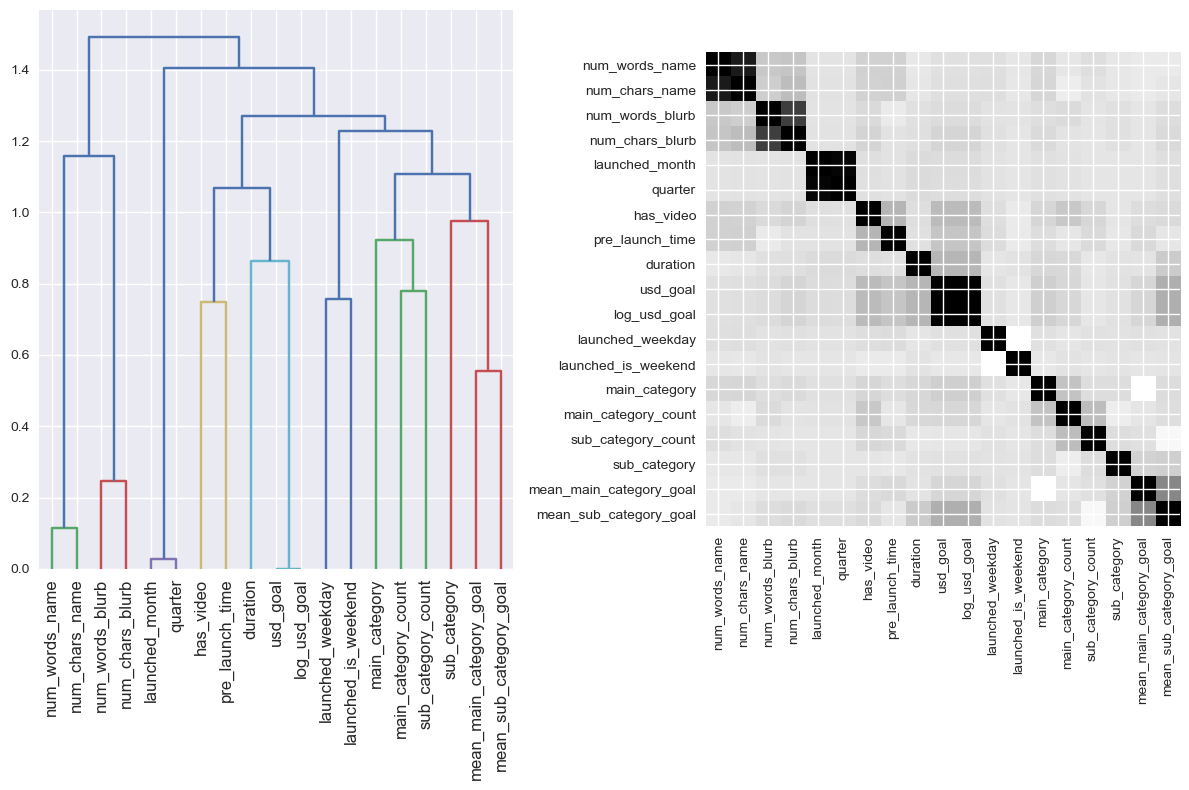

In [53]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()
plt.savefig('images/variables_correlation.jpg')

Next, we manually pick a threshold by visual inspection of the dendrogram to group our features into clusters and choose a feature from each cluster to keep, select those features from our dataset, and train a new random forest. The test accuracy of the new random forest did not change much compared to the random forest trained on the complete dataset.

In [54]:
cluster_ids = hierarchy.fcluster(dist_linkage, 0.8, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]

categorical_columns_2 = [x for x in categorical_columns if x in selected_features_names]
numerical_columns_2 = [x for x in numerical_columns if x in selected_features_names]
X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

print(f'categorical variables after selection: {categorical_columns_2}')
print(f'numerical variables after selection: {numerical_columns_2}')

categorical variables after selection: ['launched_month', 'launched_weekday', 'main_category', 'sub_category', 'has_video']
numerical variables after selection: ['duration', 'mean_main_category_goal', 'main_category_count', 'num_words_name', 'num_words_blurb', 'usd_goal']


In [55]:
rf = RandomForestClassifier(random_state=6740,min_samples_leaf=10)
rf_3 = train_rf(rf, X_train_sel, y_train, categorical_columns_2, numerical_columns_2)
print(f"RF train accuracy with features removed: {rf_3.score(X_train_sel, y_train):.3f}")
print(f"RF test accuracy with features removed: {rf_3.score(X_test_sel, y_test):.3f}")

RF train accuracy with features removed: 0.831
RF test accuracy with features removed: 0.767


We can finally explore the permutation importance of the selected subset of features:

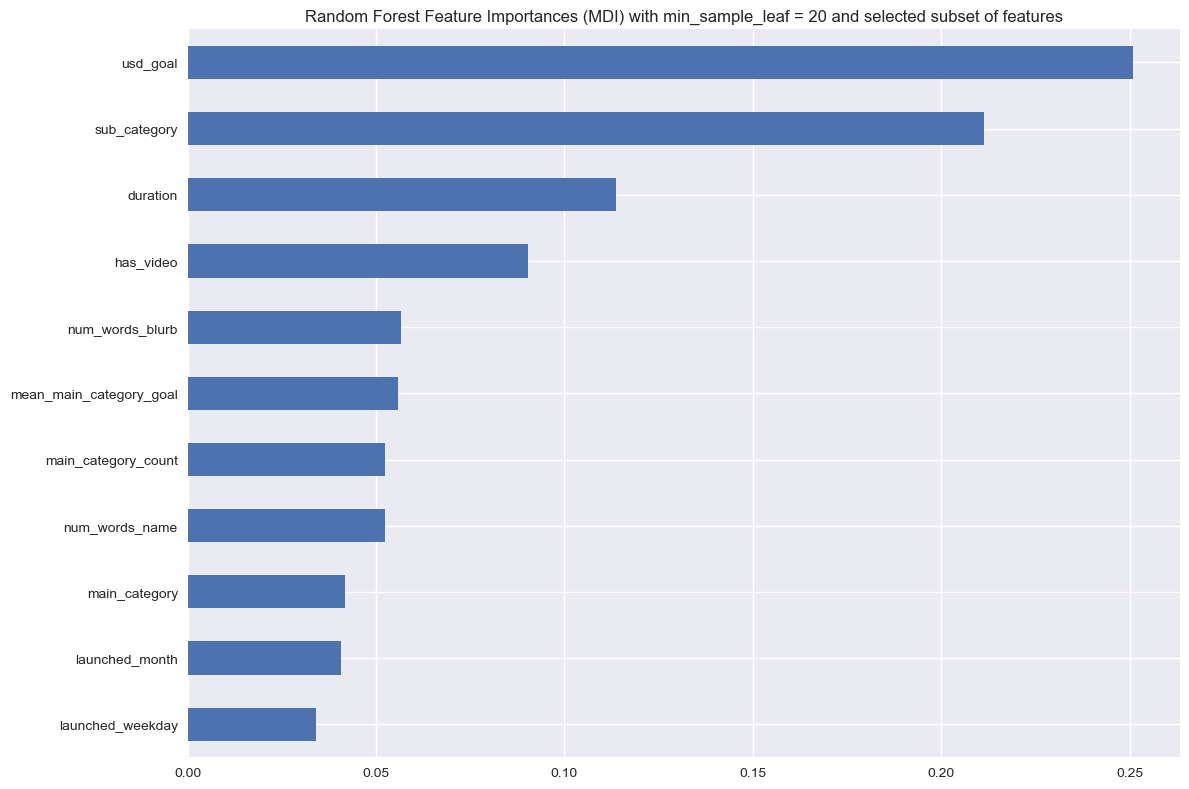

In [56]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
plot_MDI(rf_3, ax, title="Random Forest Feature Importances (MDI) with min_sample_leaf = 20 and selected subset of features")
plt.tight_layout()
plt.savefig('images/rf3_MDI.jpg')

In [57]:
importances_test = get_permutation_importance(rf_3, X_test_sel, y_test)
# importances_train = get_permutation_importance(rf_3, X_train_sel, y_train)

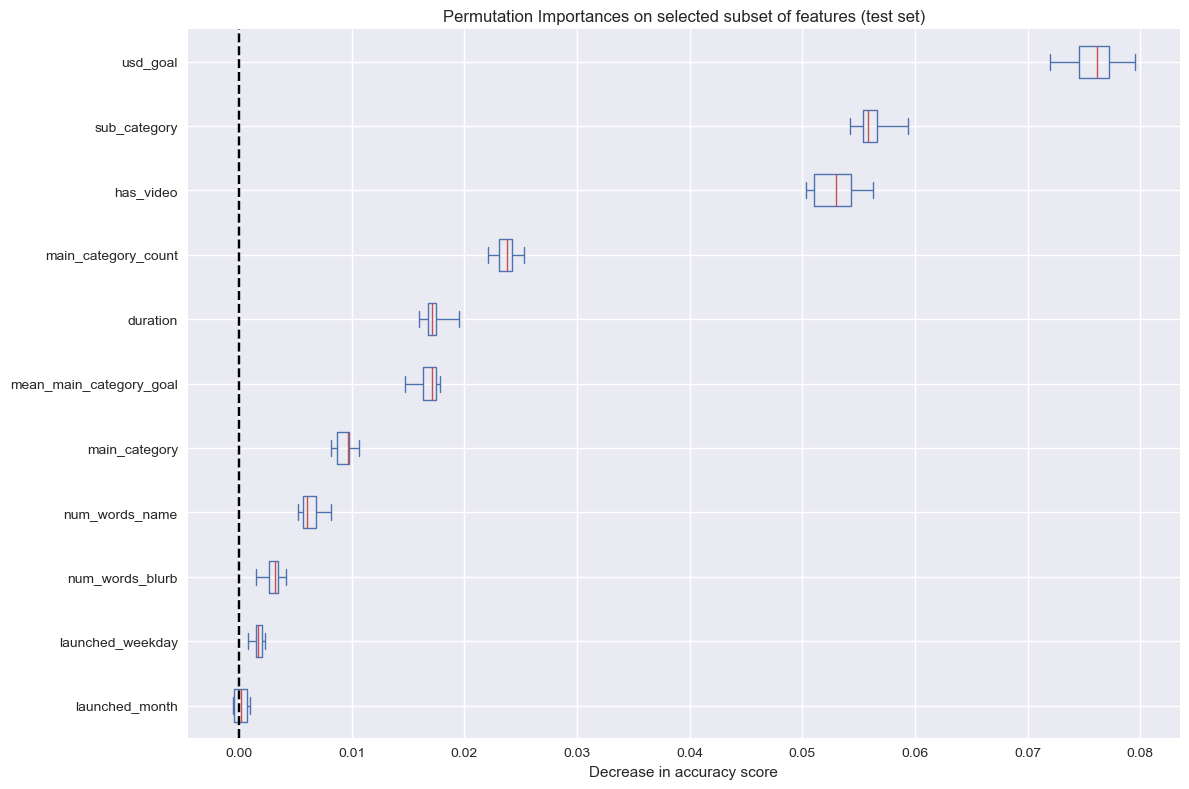

In [58]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
# plot_permutation_importance(importances_train, ax1, title='Permutation Importances on selected subset of features (train set)')
plot_permutation_importance(importances_test, ax, title='Permutation Importances on selected subset of features (test set)')
plt.tight_layout()
plt.savefig('images/rf3_permutation_test.jpg')
plt.show()

## 4.4 Pressence of which keywords makes the biggest impact in the predictions?

Using permutation importance, we can also evaluate which keywords makes the biggest impact in the model prediction. Let's train another model which also uses keywords used in the project name and observe the permutation importance.

In [59]:
def clean_name(x):
    words = x.lower().split()
    cln = [wrd for wrd in words if not wrd[0].isdigit()]
    return " ".join(cln)
data["cleaned_name"] = data["name"].apply(lambda x : clean_name(x))

## add text features : top 100
vec = TfidfVectorizer(max_features=100, ngram_range=(1, 2), lowercase=True, stop_words="english", min_df=6)
X = vec.fit_transform(data['cleaned_name'].values)

## append to original dataframe
vectors_df = pd.DataFrame(X.toarray(), columns=["_"+xx for xx in vec.get_feature_names_out()])
data1_df = pd.concat([data[column_for_testing], vectors_df], axis=1)

In [60]:
## train the model
X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(data1_df, y, test_size = 0.15, random_state = 6740)
# X_train_vec, y_train_vec = X_train[:15000], y_train[:15000]
# X_test_vec, y_test_vec = X_test[:1000], y_test[:1000]

In [61]:
rf = RandomForestClassifier(random_state=6740, min_samples_leaf=20)
rf_4 = train_rf(rf, X_train_vec, y_train_vec, categorical_columns, numerical_columns+vectors_df.columns.tolist())
print(f"RF train accuracy: {rf_4.score(X_train_vec, y_train_vec):.3f}")
print(f"RF test accuracy: {rf_4.score(X_test_vec, y_test_vec):.3f}")

RF train accuracy: 0.805
RF test accuracy: 0.781


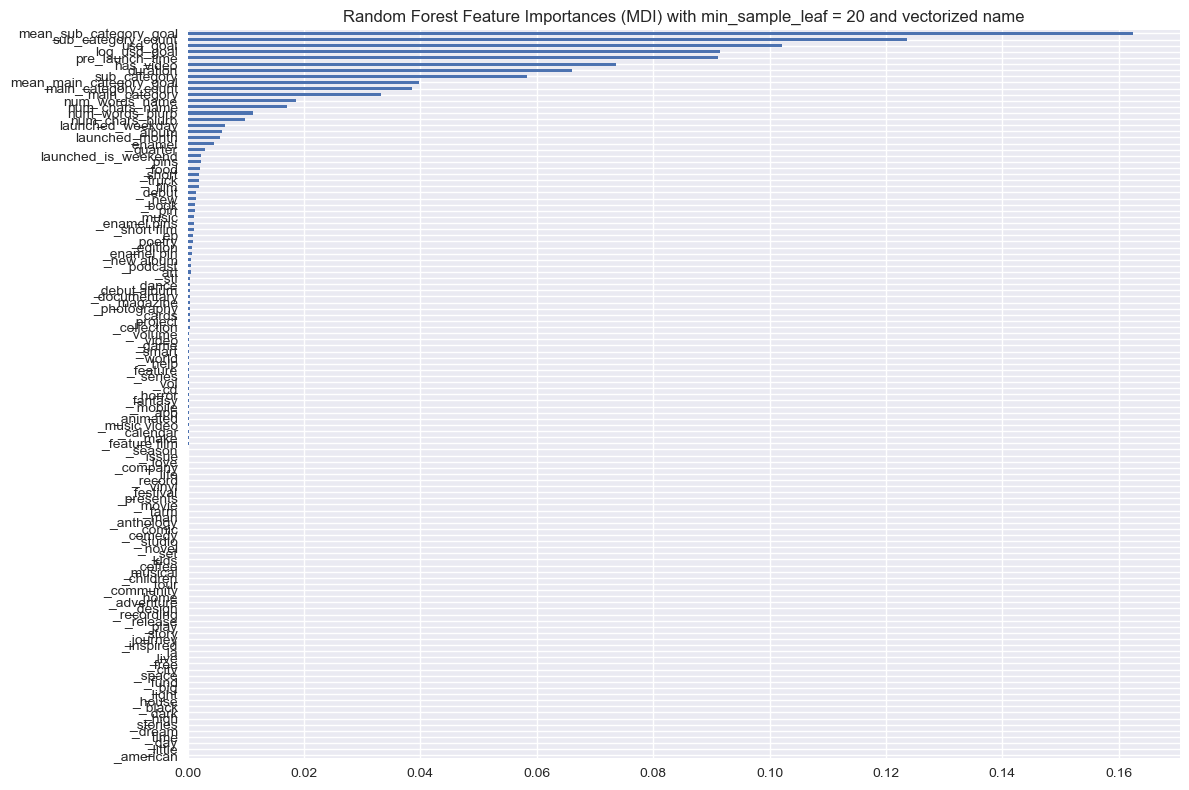

In [62]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
plot_MDI(rf_4, ax, title="Random Forest Feature Importances (MDI) with min_sample_leaf = 20 and vectorized name")

In [63]:
importances_test = get_permutation_importance(rf_4, X_test_vec, y_test_vec)
# importances_train = get_permutation_importance(rf_4, X_train_vec, y_train_vec)

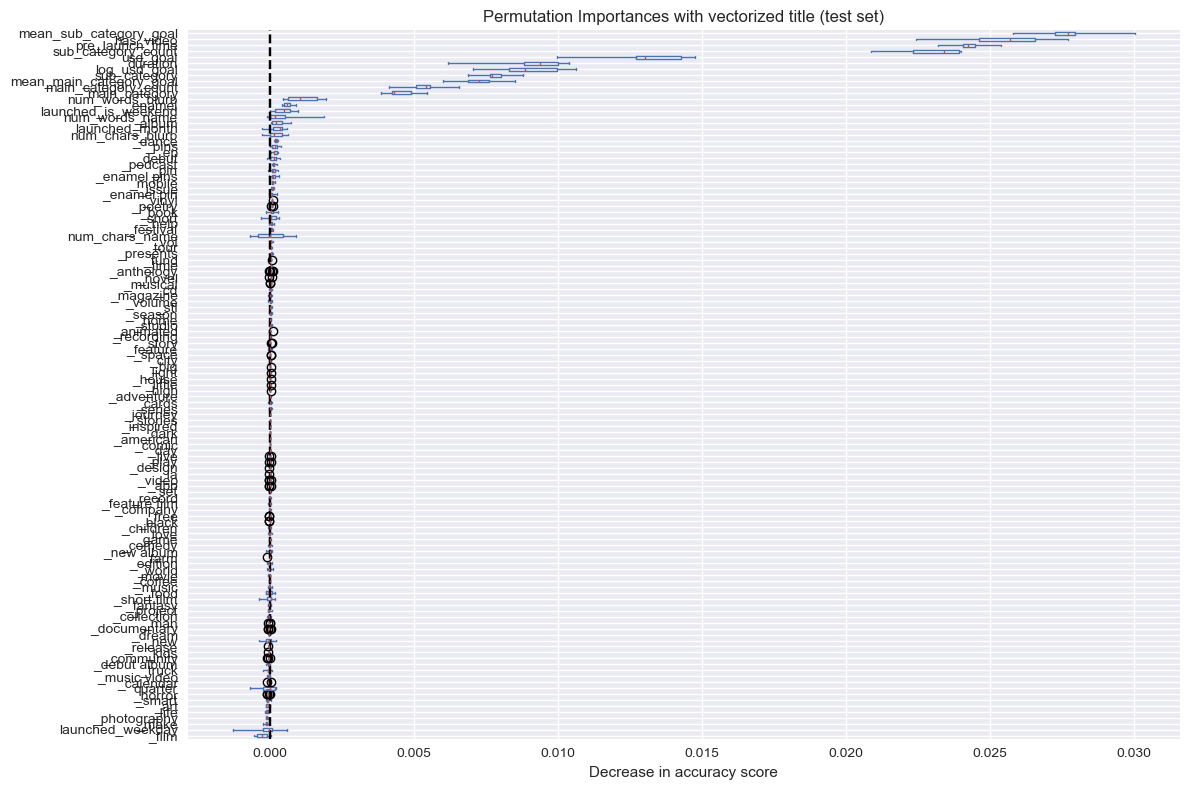

In [64]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
# plot_permutation_importance(importances_train, ax1, title='Permutation Importances with vectorized title (train set)')
plot_permutation_importance(importances_test, ax, title='Permutation Importances with vectorized title (test set)')
plt.show()

In [65]:
word_importance_mean = importances_test[vectors_df.columns].mean()
word_importance_mean = word_importance_mean.sort_values()

word_importance_top10 = word_importance_mean[-10:][::-1]
word_importance_bot10 = word_importance_mean[:10]

[]

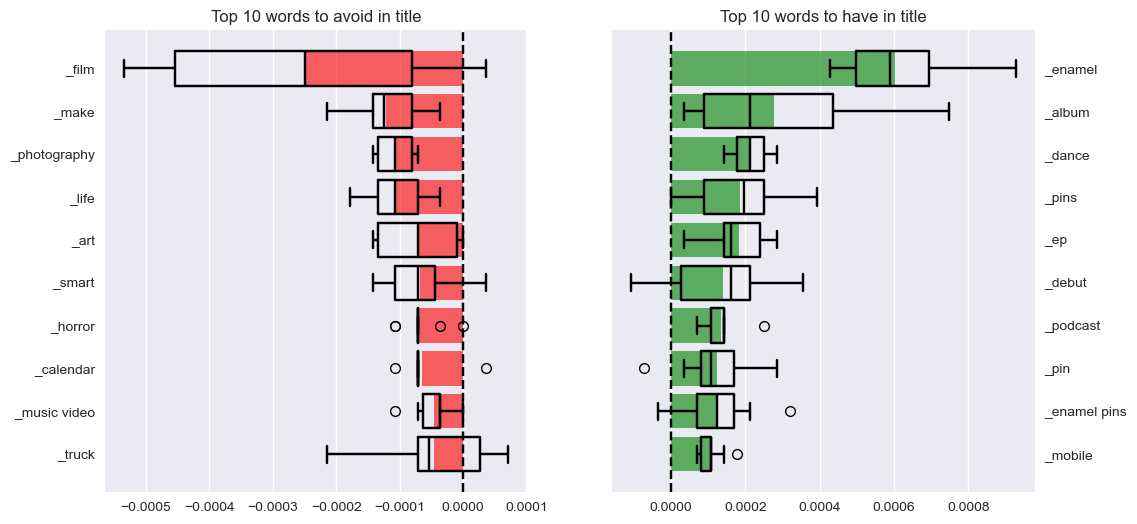

In [66]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
# Plot horizontal bars for means

sns.boxplot(data=importances_test[word_importance_bot10.index], ax=ax1, orient='h', fill=False, color='black')
ax1.barh(y=range(word_importance_bot10.shape[0]), width=word_importance_bot10, color='red', alpha=0.6)
ax1.set_yticks(range(word_importance_top10.shape[0]), word_importance_bot10.index.to_list())
ax1.axvline(x=0, color="k", linestyle="--")
ax1.set_title('Top 10 words to avoid in title')

sns.boxplot(data=importances_test[word_importance_top10.index], ax=ax2, orient='h', fill=False, color='black')
ax2.barh(y=range(word_importance_top10.shape[0]), width=word_importance_top10, color='green', alpha=0.6)
ax2.set_yticks(range(word_importance_top10.shape[0]), word_importance_top10.index.to_list())
ax2.axvline(x=0, color="k", linestyle="--")
ax2.set_title('Top 10 words to have in title')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
plt.savefig('images/top_words.jpg')
plt.plot()

## 4.5 How does changes in features lead to changes in model outcome? (**Partial Dependencies**)

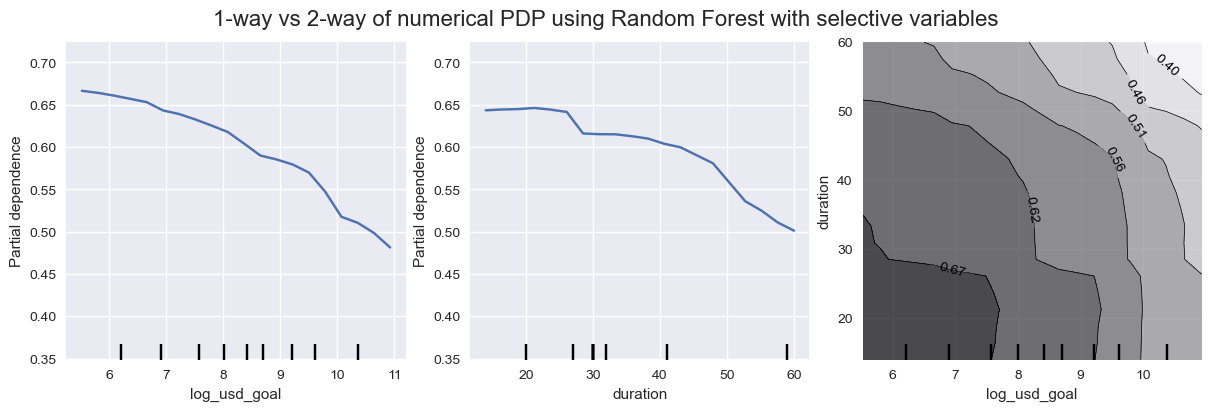

In [67]:
common_params = {
    "subsample": 1000,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

features_info = {
    "features":  ['log_usd_goal', 'duration', ('log_usd_goal', 'duration')],
    "kind": "average",
}
_, ax = plt.subplots(ncols=3, figsize=(12, 4), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    rf_2,
    X_test,
    **features_info,
    ax=ax,
    **common_params,
)
_ = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using Random Forest with selective variables", fontsize=16
)
plt.savefig('images/PDP_usdgoal_duration.jpg')

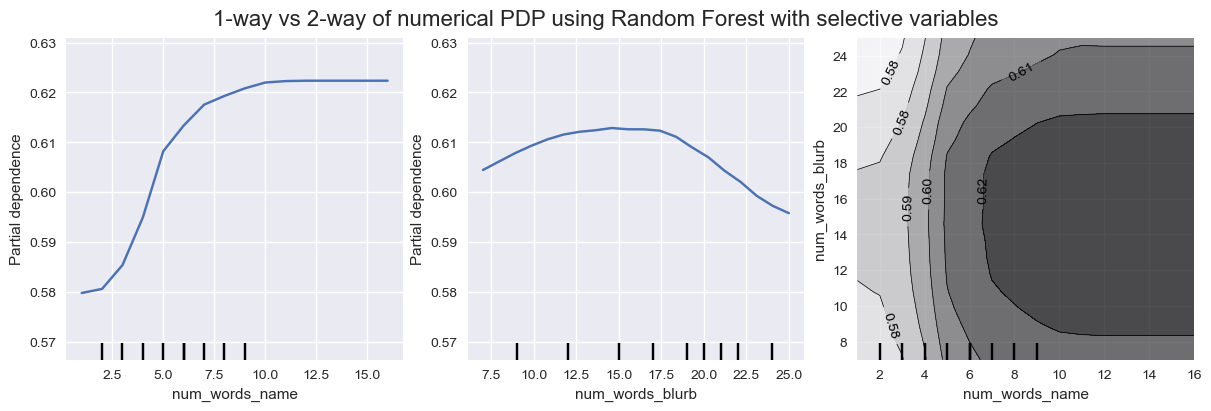

In [68]:
common_params = {
    "subsample": 1000,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

features_info = {
    "features":  ['num_words_name', 'num_words_blurb', ('num_words_name', 'num_words_blurb')],
    "kind": "average",
}
_, ax = plt.subplots(ncols=3, figsize=(12, 4), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    rf_2,
    X_test,
    **features_info,
    ax=ax,
    **common_params,
)
_ = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using Random Forest with selective variables", fontsize=16
)
plt.savefig('images/PDP_name_blurb_words.jpg')

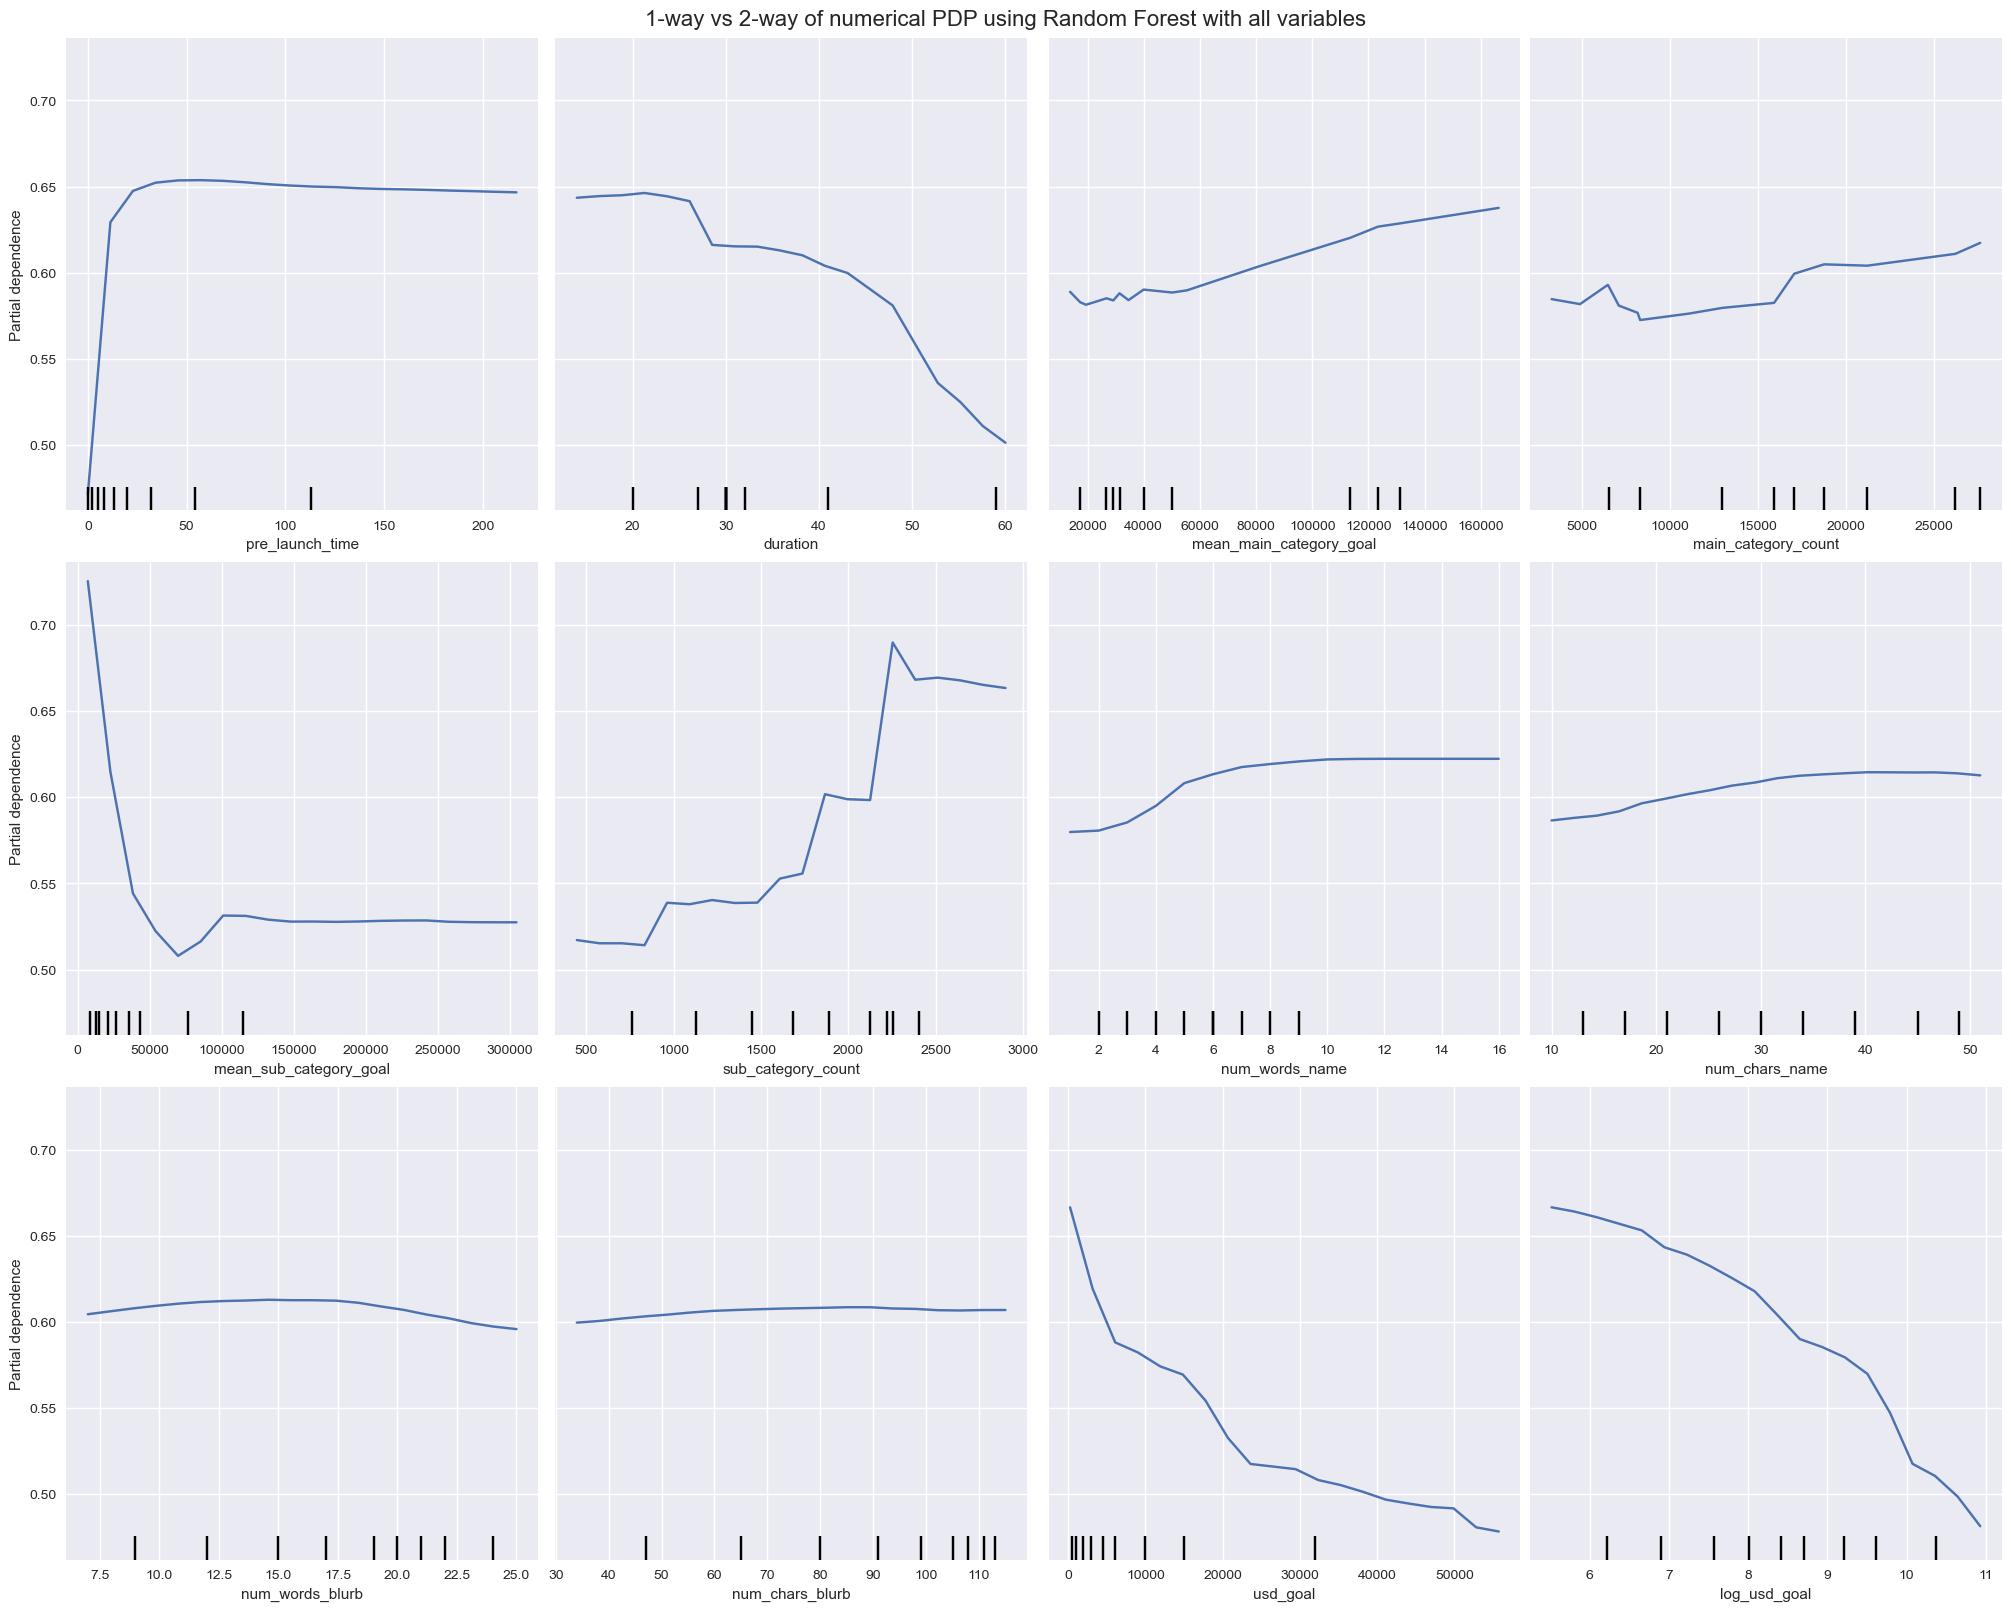

In [69]:
common_params = {
    "subsample": 1000,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

features_info = {
    "features":  numerical_columns,
    "kind": "average",
}
_, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 16), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    rf_2,
    X_test,
    **features_info,
    ax=ax,
    **common_params,
)
_ = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using Random Forest with all variables", fontsize=16
)
plt.savefig('images/PDP_name_all_numerical_variables.jpg')

## 4.6 Understanding the decisions made by the Model (using SHAP)

In [70]:
import shap 
shap.initjs()

In [71]:
def print_accuracy(f):
    print(f"Accuracy = {100 * np.sum(f(X_test) == Y_test) / len(Y_test)}%")
    time.sleep(0.5)  # to let the print get out before any progress bars

In [84]:
model = rf_2[-1]
sample = X_test.iloc[[121]]
print(sample)
sample_transformed = rf_2.named_steps['preprocess'].transform(sample)

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(sample_transformed)


shap.force_plot(
    explainer.expected_value[1], 
    shap_values[0][:,1], 
    sample_transformed, 
    feature_names=rf_2.named_steps["preprocess"].get_feature_names_out()
)

plt.savefig('images/SHAP_sample.jpg')

       launched_month launched_weekday  launched_is_weekend  quarter  \
55988               8          Tuesday                    0        3   

      main_category sub_category  has_video  pre_launch_time  duration  \
55988    Technology     Software          1                1        54   

       mean_main_category_goal  main_category_count  mean_sub_category_goal  \
55988            113533.376247                18748           128134.196898   

       sub_category_count  num_words_name  num_chars_name  num_words_blurb  \
55988                1615               8              49               18   

       num_chars_blurb  usd_goal  log_usd_goal  
55988               93   12500.0      9.433484  


<Figure size 800x550 with 0 Axes>

In [78]:
pred = rf_2.predict(X_test)

In [79]:
train_sample_transformed = rf_2.named_steps['preprocess'].transform(X_train[:100])
explainer2 = shap.KernelExplainer(model.predict_proba, train_sample_transformed)

In [83]:
test_sample_transformed = rf_2.named_steps['preprocess'].transform(X_test[121:122])
shap_values2 = explainer2.shap_values(test_sample_transformed)
shap.force_plot(explainer2.expected_value[0], shap_values2[..., 0]
                , test_sample_transformed, feature_names=rf_2.named_steps["preprocess"].get_feature_names_out())

  0%|          | 0/1 [00:00<?, ?it/s]

In [76]:
model.predict_proba(sample_transformed)

array([[0.0036012, 0.9963988]])

In [82]:
X_test_s = X_test.head(1000)
X_test_transformed = rf_2.named_steps['preprocess'].transform(X_test_s)
shap_values_2 = explainer.shap_values(X_test_transformed)


In [83]:
shap_values_2[:,:,1].shape

(1000, 19)

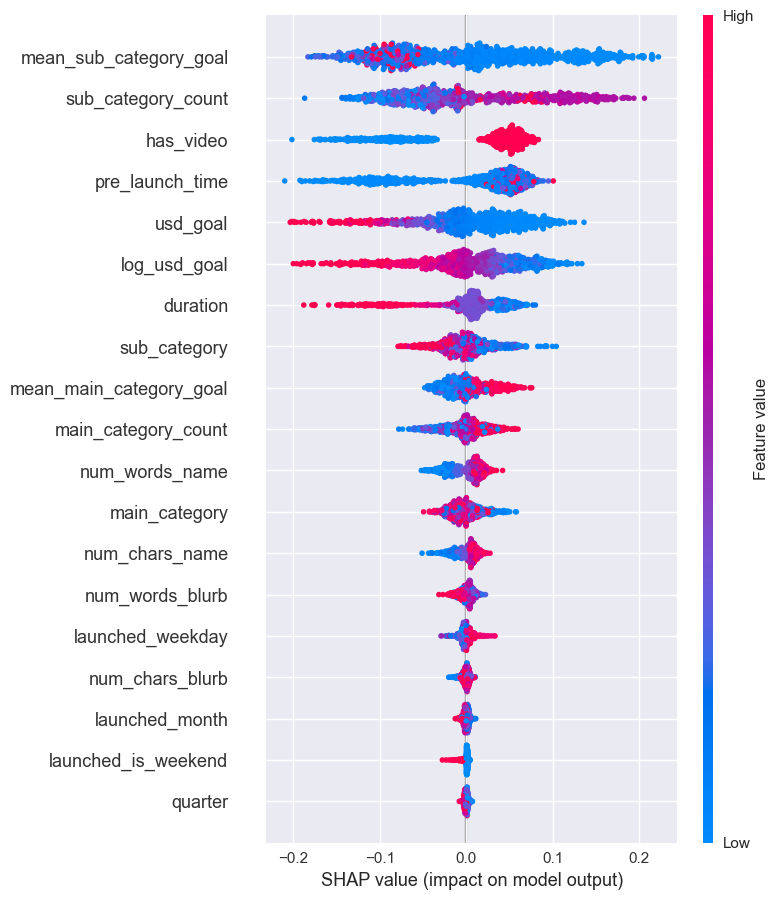

In [88]:
shap.summary_plot(shap_values_2[:,:,1], X_test_transformed, feature_names=rf_2.named_steps["preprocess"].get_feature_names_out(), show=False)
plt.tight_layout()
plt.savefig('images/SHAP_summary_successful2.jpg')

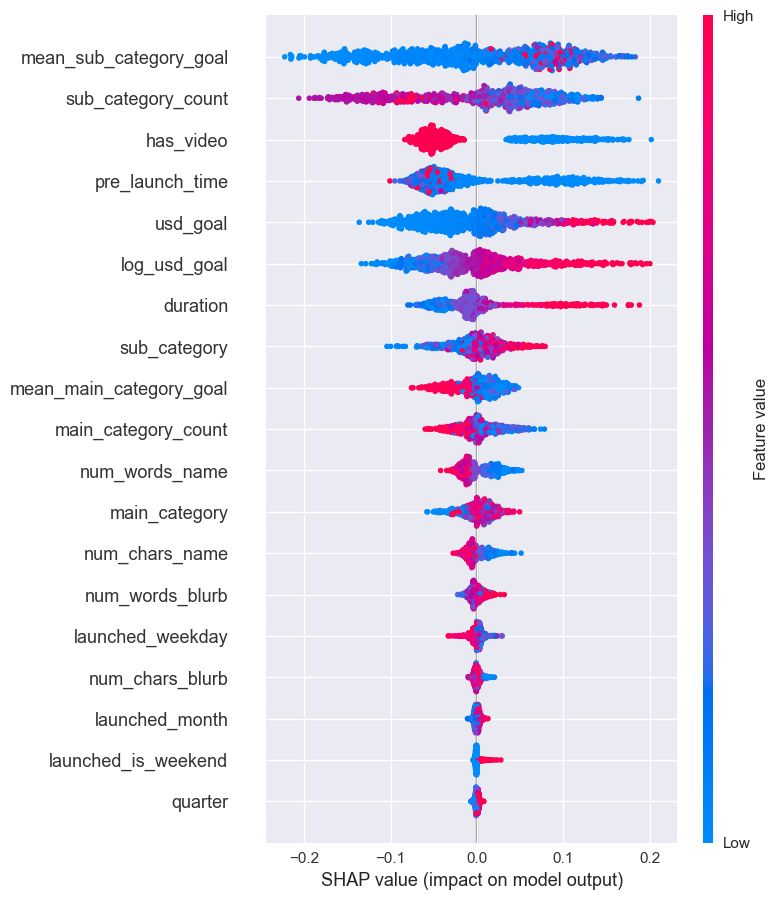

In [90]:
shap.summary_plot(shap_values_2[:,:,0], X_test_transformed, feature_names=rf_2.named_steps["preprocess"].get_feature_names_out(), show=False)
plt.tight_layout()
plt.savefig('images/SHAP_summary_failed.jpg')

In [348]:
explainer(sample_transformed)

.values =
array([[[ 2.59117051e-03, -2.59117051e-03],
        [ 2.20806692e-03, -2.20806692e-03],
        [ 4.42122539e-03, -4.42122539e-03],
        [ 1.34519349e-03, -1.34519349e-03],
        [-4.51908394e-04,  4.51908394e-04],
        [-1.81077734e-02,  1.81077734e-02],
        [-2.95990788e-02,  2.95990788e-02],
        [-1.27167348e-02,  1.27167348e-02],
        [-6.19441978e-03,  6.19441978e-03],
        [-1.90126904e-03,  1.90126904e-03],
        [-1.97858984e-02,  1.97858984e-02],
        [-1.33899714e-01,  1.33899714e-01],
        [-1.13810596e-01,  1.13810596e-01],
        [-3.61113373e-03,  3.61113373e-03],
        [-4.19881654e-03,  4.19881654e-03],
        [ 4.25381383e-03, -4.25381383e-03],
        [-3.65233241e-05,  3.65233241e-05],
        [-3.04448888e-02,  3.04448888e-02],
        [-2.80108019e-02,  2.80108019e-02]]])

.base_values =
array([[0.39155129, 0.60844871]])

.data =
array([[1.00000000e+01, 3.00000000e+00, 1.00000000e+00, 3.00000000e+00,
        1.00000000e+0

In [347]:
# visualize the first prediction's explanation
# shap.plots.waterfall(explainer(sample_transformed)[0])

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (19, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [222]:
sample_transformed

array([[1.00000000e+01, 3.00000000e+00, 1.00000000e+00, 3.00000000e+00,
        1.00000000e+01, 3.00000000e+01, 1.00000000e+00, 7.00000000e+00,
        3.00000000e+01, 2.67507468e+04, 2.61970000e+04, 8.51702452e+03,
        2.24300000e+03, 5.00000000e+00, 3.20000000e+01, 2.40000000e+01,
        1.12000000e+02, 1.29270000e+03, 7.16448833e+00]])

In [210]:
arr = np.random.rand(10,10)

In [211]:
arr

array([[0.90205447, 0.42247371, 0.89456812, 0.89544988, 0.68299419,
        0.25419736, 0.83022982, 0.97171307, 0.16478565, 0.18147676],
       [0.3851858 , 0.53477882, 0.4361957 , 0.49608503, 0.05349251,
        0.77909508, 0.10327184, 0.97114917, 0.40955015, 0.63077636],
       [0.5371611 , 0.6734714 , 0.49386386, 0.58889956, 0.67408486,
        0.25296866, 0.59498227, 0.39512915, 0.8437551 , 0.13049525],
       [0.06643439, 0.71904557, 0.13548872, 0.23995071, 0.46508871,
        0.04029929, 0.77187169, 0.58998238, 0.34095563, 0.72542373],
       [0.04809811, 0.31398932, 0.85704118, 0.79666309, 0.35218533,
        0.97176628, 0.84642458, 0.39036023, 0.17625833, 0.91294756],
       [0.37078765, 0.95644454, 0.9195059 , 0.72892292, 0.45185258,
        0.65785618, 0.86875569, 0.61571777, 0.84249769, 0.43587641],
       [0.16176028, 0.79997014, 0.01007625, 0.15080521, 0.59300213,
        0.51402386, 0.91891245, 0.25610699, 0.0836617 , 0.10507992],
       [0.6434885 , 0.01843766, 0.7413503

In [340]:
import xgboost
import shap

# train an XGBoost model
XX, yy = shap.datasets.california()
model = xgboost.XGBRegressor().fit(XX, yy)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(XX)



In [341]:
shap_values

.values =
array([[ 1.7081785 ,  0.09363674,  0.19277047, ...,  0.01571906,
        -0.39385185,  0.55515116],
       [ 1.426717  ,  0.03108795,  0.00601703, ...,  0.2112088 ,
        -0.36280793,  0.5884698 ],
       [ 1.3600677 ,  0.16082455,  0.47361216, ..., -0.02257477,
        -0.5582292 ,  0.5463798 ],
       ...,
       [-0.5842778 ,  0.01744973, -0.0949486 , ...,  0.10111337,
        -0.9798146 ,  0.3479332 ],
       [-0.6035651 ,  0.03118367, -0.05752674, ...,  0.23118298,
        -1.051862  ,  0.32962263],
       [-0.44976887,  0.02051439, -0.12479055, ..., -0.00343278,
        -0.85543966,  0.33553985]], shape=(20640, 8), dtype=float32)

.base_values =
array([2.0684865, 2.0684865, 2.0684865, ..., 2.0684865, 2.0684865,
       2.0684865], shape=(20640,), dtype=float32)

.data =
array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86  

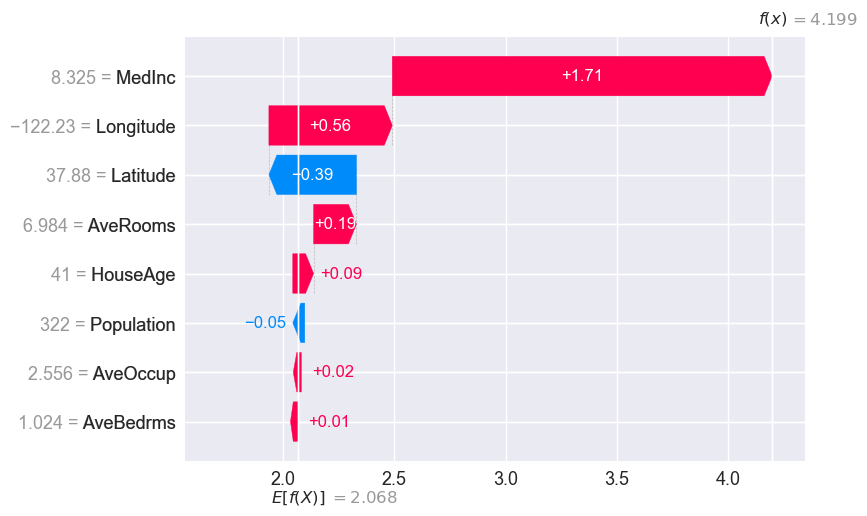

In [285]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])